In [2]:
import json
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras import initializers

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(42)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

initializers_list = [
    initializers.RandomNormal,
    initializers.RandomUniform,
    initializers.TruncatedNormal,
    initializers.VarianceScaling,
    initializers.GlorotNormal,
    initializers.GlorotUniform,
    initializers.HeNormal,
    initializers.HeUniform,
    initializers.LecunNormal,
    initializers.LecunUniform,
    initializers.Orthogonal,
]

for initializer in initializers_list:
    print(f"Running {initializer}")

    for iteration in range(2):
        # In order to get same results across multiple runs from an initializer,
        # you can specify a seed value.
        result = float(initializer(seed=42)(shape=(1, 1)))
        print(f"\tIteration --> {iteration} // Result --> {result}")
    print("\n")


Running <class 'keras.src.initializers.initializers.RandomNormal'>
	Iteration --> 0 // Result --> 0.000790853810030967
	Iteration --> 1 // Result --> 0.000790853810030967


Running <class 'keras.src.initializers.initializers.RandomUniform'>
	Iteration --> 0 // Result --> -0.02175668440759182
	Iteration --> 1 // Result --> -0.02175668440759182


Running <class 'keras.src.initializers.initializers.TruncatedNormal'>
	Iteration --> 0 // Result --> 0.000790853810030967
	Iteration --> 1 // Result --> 0.000790853810030967


Running <class 'keras.src.initializers.initializers.VarianceScaling'>
	Iteration --> 0 // Result --> 0.017981600016355515
	Iteration --> 1 // Result --> 0.017981600016355515


Running <class 'keras.src.initializers.initializers.GlorotNormal'>
	Iteration --> 0 // Result --> 0.017981600016355515
	Iteration --> 1 // Result --> 0.017981600016355515


Running <class 'keras.src.initializers.initializers.GlorotUniform'>
	Iteration --> 0 // Result --> -0.7536736726760864
	Iterati

In [3]:
from services.load_dataset import load_data
import pickle

X_train, X_val, X_test, y_train, y_val, y_test  = load_data(data_folder='data')

best_hp = pickle.load(open('model/best_hp.pkl', 'rb'))
best_hp = best_hp.values

In [4]:
"""from services.modeling import *

hypermodel = LSTMHyperModel(X_train=X_train, labels=y_train, dp=True, dp_num_microbatches=1, noise_multiplier=noise_multiplier)
# Load the tuner results
tuner = kt.RandomSearch(
    hypermodel,
    objective=kt.Objective('val_recall', direction='max'),
    max_trials=10,         # Increase for a more thorough search
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='dp_credit_card_fraud_lstm'
)

tuner.search()

# Get the best hyperparameters and model
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_seq_length = best_hp.get('sequence_length')

# For final evaluation, generate a test set using the best sequence length.
X_train_final, y_train_final = create_sequences(X_train, y_train, best_seq_length)
X_test_final, y_test_final = create_sequences(X_test, y_test, best_seq_length)

# Apply SMOTE on the training set
n_samples, seq_len, n_features_local = X_train_final.shape
X_train_final_flat = X_train_final.reshape(n_samples, seq_len * n_features_local)
smote = SMOTE(random_state=42, sampling_strategy=0.25)
X_train_final_res, y_train_final_res = smote.fit_resample(X_train_final_flat, y_train_final)
X_train_final_res = X_train_final_res.reshape(-1, best_seq_length, n_features_local)

# Retrieve the best model and evaluate on the test set
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy, precision, recall, auc_metric = best_model.evaluate(X_test_final, y_test_final, verbose=0)
print("Best Model Evaluation on Test Set:")
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc_metric:.4f}")
"""

'from services.modeling import *\n\nhypermodel = LSTMHyperModel(X_train=X_train, labels=y_train, dp=True, dp_num_microbatches=1, noise_multiplier=noise_multiplier)\n# Load the tuner results\ntuner = kt.RandomSearch(\n    hypermodel,\n    objective=kt.Objective(\'val_recall\', direction=\'max\'),\n    max_trials=10,         # Increase for a more thorough search\n    executions_per_trial=1,\n    directory=\'hyperparam_tuning\',\n    project_name=\'dp_credit_card_fraud_lstm\'\n)\n\ntuner.search()\n\n# Get the best hyperparameters and model\nbest_hp = tuner.get_best_hyperparameters(num_trials=1)[0]\nbest_seq_length = best_hp.get(\'sequence_length\')\n\n# For final evaluation, generate a test set using the best sequence length.\nX_train_final, y_train_final = create_sequences(X_train, y_train, best_seq_length)\nX_test_final, y_test_final = create_sequences(X_test, y_test, best_seq_length)\n\n# Apply SMOTE on the training set\nn_samples, seq_len, n_features_local = X_train_final.shape\nX_tra

In [24]:
from services.dp_modeling import train_model_with_delta

best_hp['num_microbatches'] = 1
best_hp['l2_norm_clip'] = 1.0
best_hp['learning_rate'] = 0.00001

#epsilon_values = [0.1, 1, 5, 10]
epsilon_values = [0.1, 1, 5, 10]

delta_values = [1e-6*10**(-2*i) for i in range(4)]

results_per_eps = {}

for eps in epsilon_values:
    for delta in delta_values:
        print(f"Training with delta={delta:.1e} and epsilon={eps}")
        if eps not in results_per_eps:
            results_per_eps[eps] = {}
        results_per_eps[eps][f"{delta:.1e}"] = train_model_with_delta(delta, X_train, y_train, X_val, y_val, best_hp, target_epsilon=float(eps), epochs=75, batch_size=128)


Training with delta=1.0e-06 and epsilon=0.1
δ=1.0e-06: Using noise_multiplier=356.518 (Achieved ε=0.10)
Train shape: (195317, 5, 29)
Val shape: (50779, 5, 29)
Class balance: (array([0, 1]), array([156254,  39063], dtype=int64))
Epoch 1/75
1526/1526 [==============================] - 49s 13ms/step - loss: 0.1723 - accuracy: 0.5317 - precision: 0.2245 - recall: 0.5468 - auc: 0.5550 - val_loss: 0.1771 - val_accuracy: 0.3113 - val_precision: 0.0040 - val_recall: 0.7277 - val_auc: 0.5547
Epoch 2/75
1526/1526 [==============================] - 18s 12ms/step - loss: 0.1723 - accuracy: 0.5320 - precision: 0.2243 - recall: 0.5453 - auc: 0.5546 - val_loss: 0.1770 - val_accuracy: 0.3175 - val_precision: 0.0040 - val_recall: 0.7225 - val_auc: 0.5570
Epoch 3/75
1526/1526 [==============================] - 18s 12ms/step - loss: 0.1721 - accuracy: 0.5384 - precision: 0.2261 - recall: 0.5396 - auc: 0.5561 - val_loss: 0.1768 - val_accuracy: 0.3264 - val_precision: 0.0040 - val_recall: 0.7225 - val_auc:

In [25]:
from services.modeling import create_sequences

X_train_seq, y_train_seq = create_sequences(X_train, y_train, best_hp['sequence_length'])
X_test_seq, y_test_seq = create_sequences(X_test, y_test, best_hp['sequence_length'])

Epsilon = 0.1, Delta = 1.0e-06


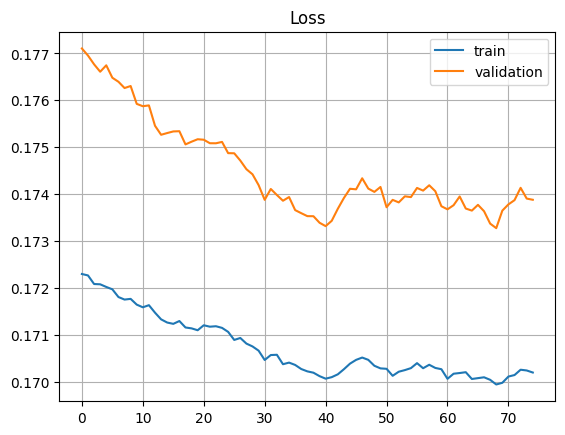

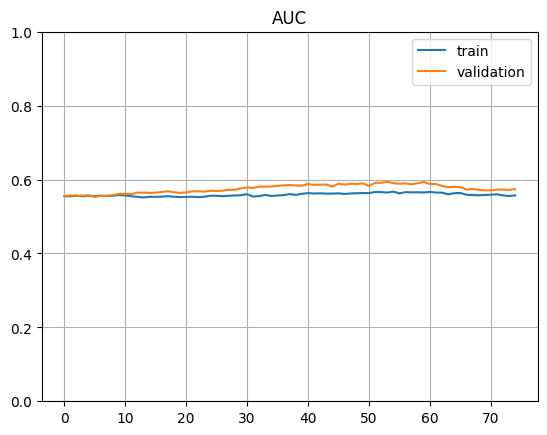

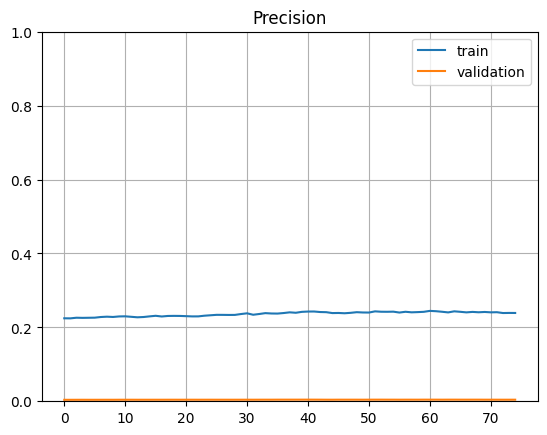

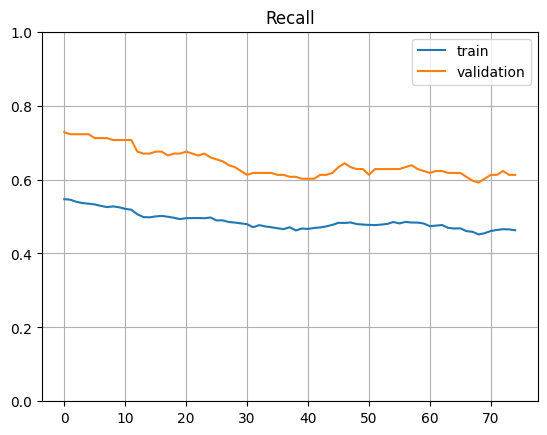

2380/2380 [==============================] - 9s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.45      0.62     75668
           1       0.01      0.71      0.02       484

    accuracy                           0.45     76152
   macro avg       0.50      0.58      0.32     76152
weighted avg       0.99      0.45      0.62     76152

Confusion Matrix:


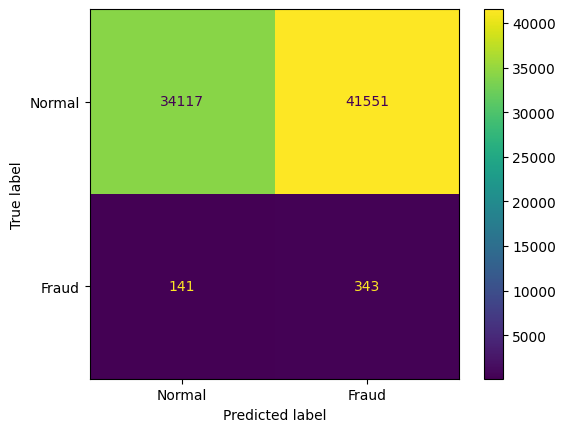

2380/2380 [==============================] - 7s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epsilon = 0.101, Delta = 1.0e-08


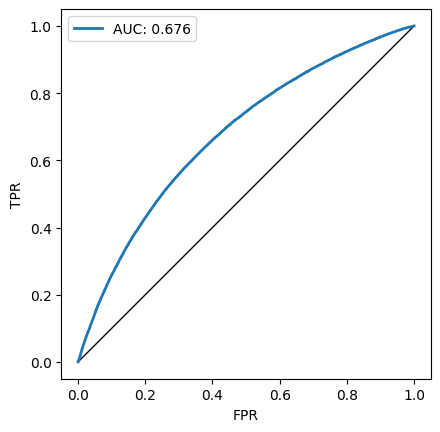

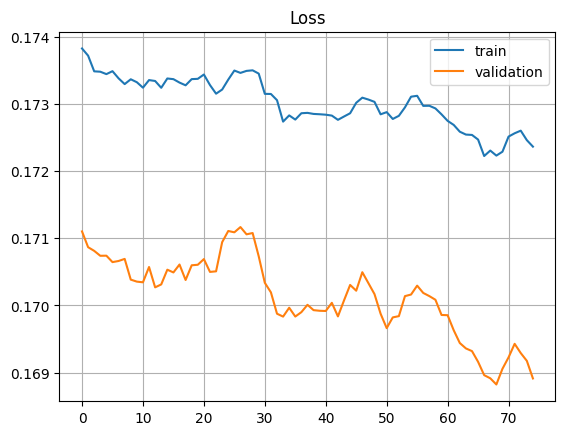

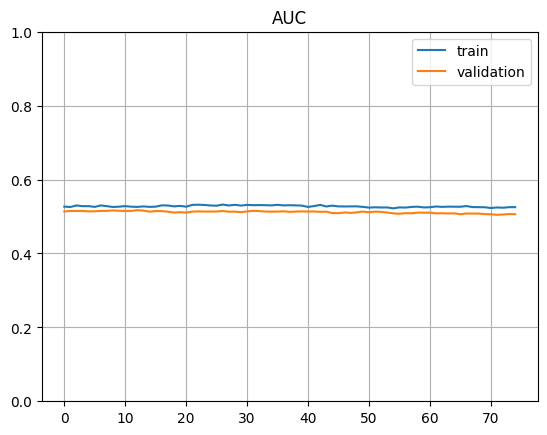

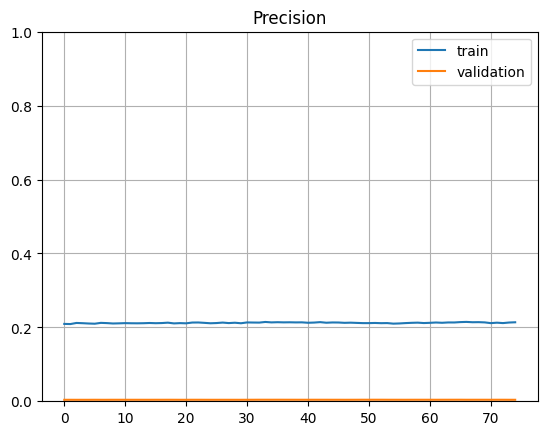

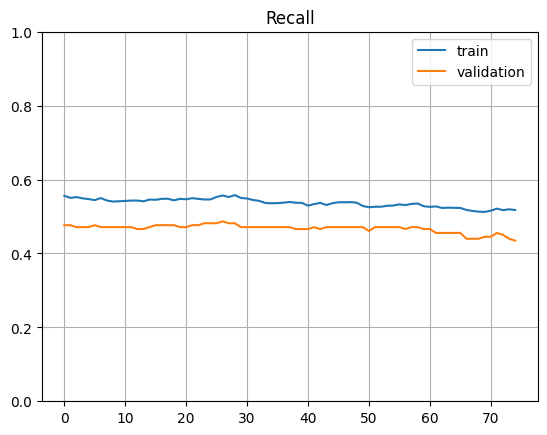

2380/2380 [==============================] - 8s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.60      0.75     75668
           1       0.01      0.49      0.02       484

    accuracy                           0.60     76152
   macro avg       0.50      0.54      0.38     76152
weighted avg       0.99      0.60      0.74     76152

Confusion Matrix:


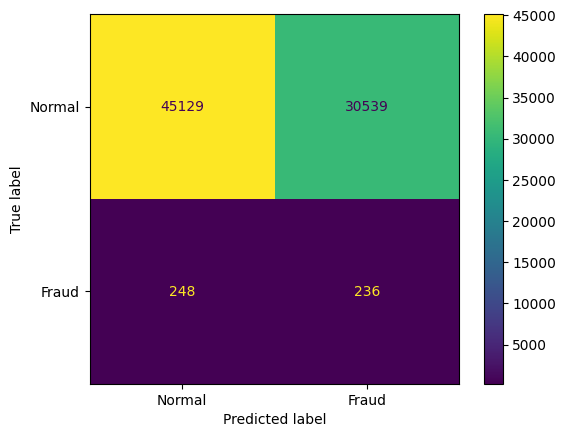

2380/2380 [==============================] - 7s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epsilon = 0.1, Delta = 1.0e-10


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


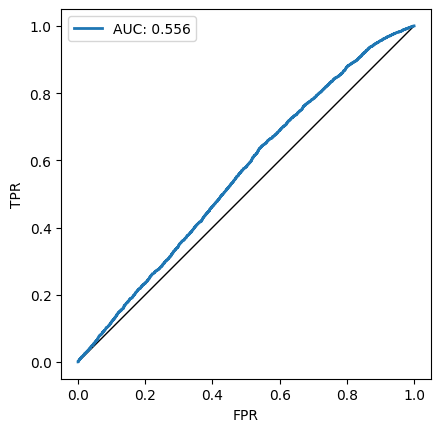

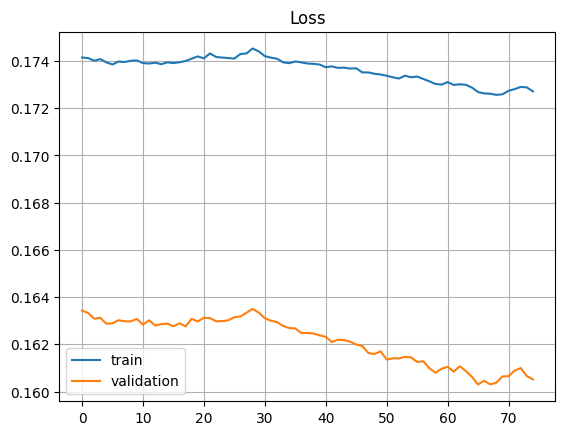

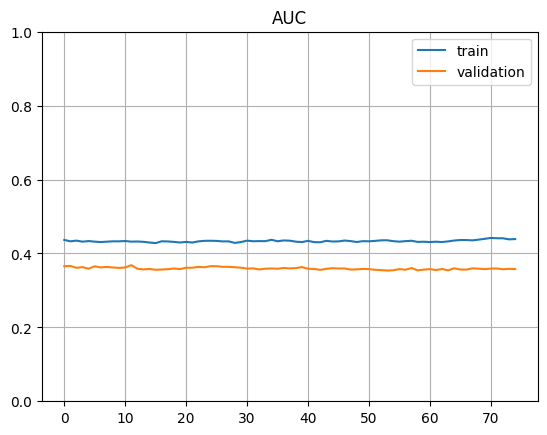

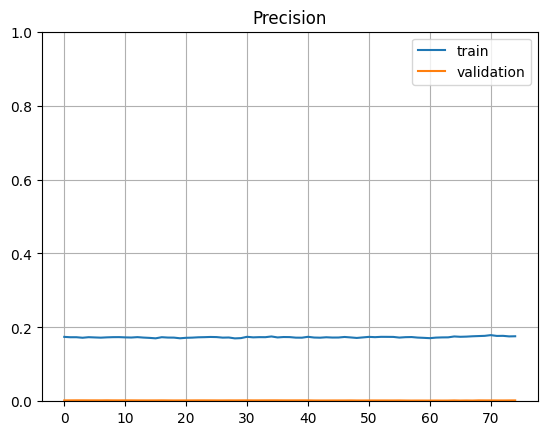

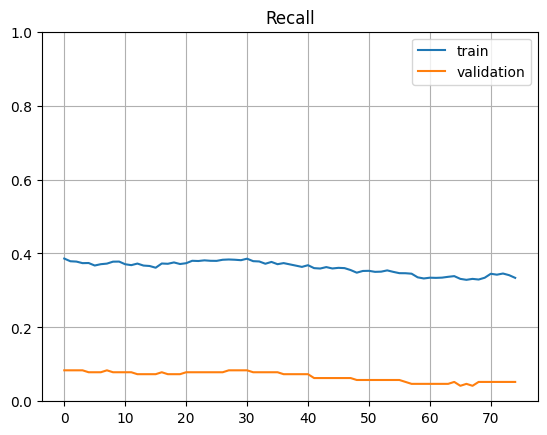

2380/2380 [==============================] - 9s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.92      0.96     75668
           1       0.01      0.07      0.01       484

    accuracy                           0.92     76152
   macro avg       0.50      0.50      0.48     76152
weighted avg       0.99      0.92      0.95     76152

Confusion Matrix:


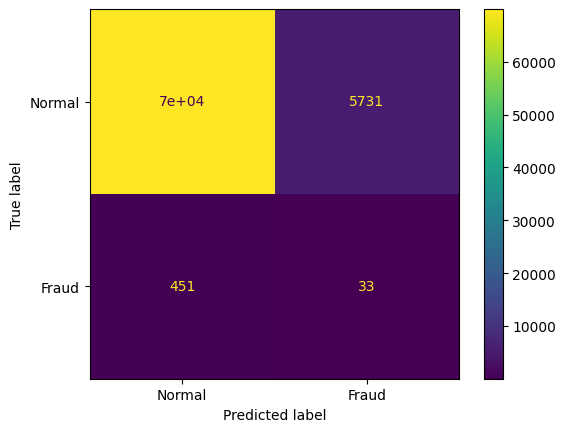

2380/2380 [==============================] - 7s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epsilon = 0.1, Delta = 1.0e-12


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


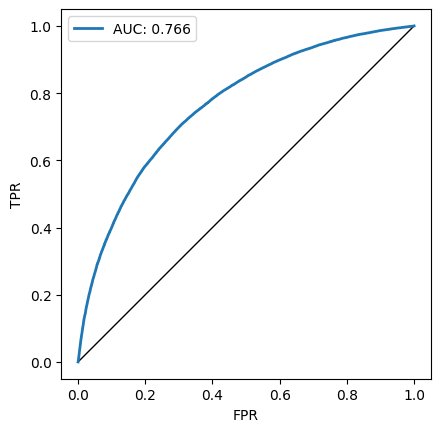

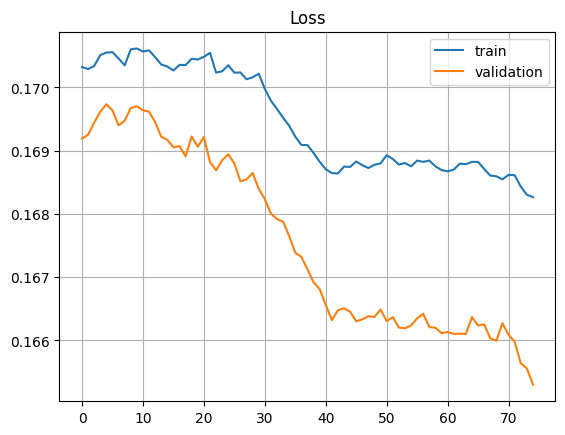

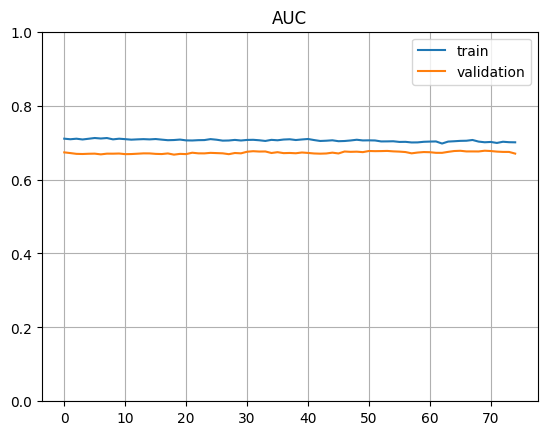

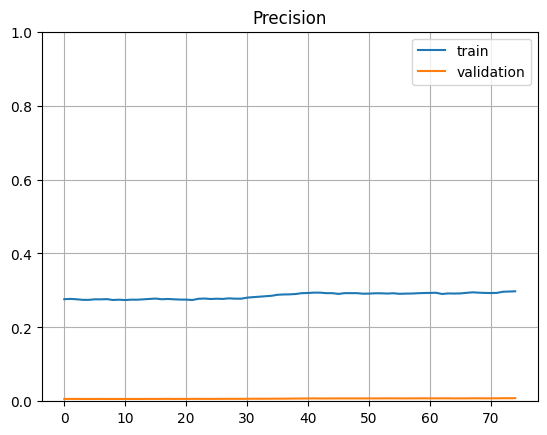

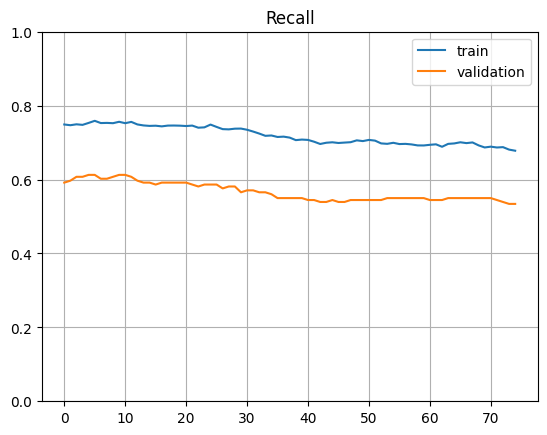

2380/2380 [==============================] - 9s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.79      0.88     75668
           1       0.02      0.59      0.03       484

    accuracy                           0.79     76152
   macro avg       0.51      0.69      0.46     76152
weighted avg       0.99      0.79      0.87     76152

Confusion Matrix:


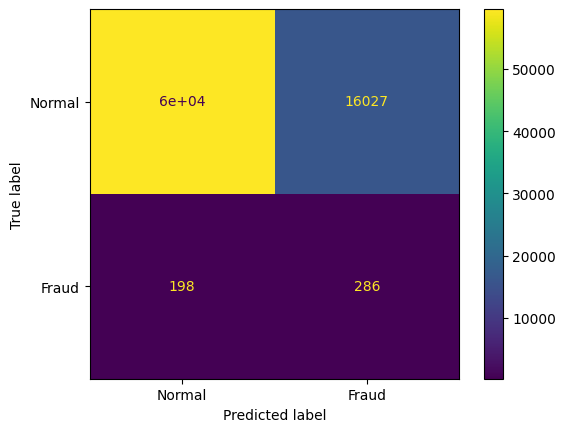

2380/2380 [==============================] - 8s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epsilon = 1.001, Delta = 1.0e-06


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


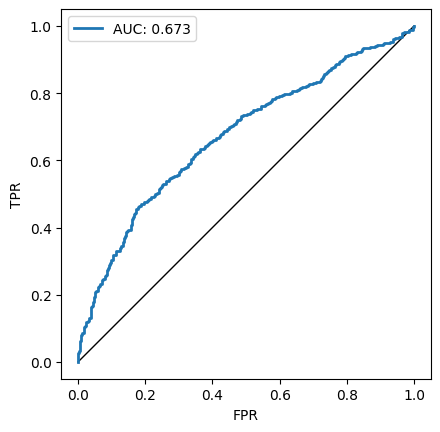

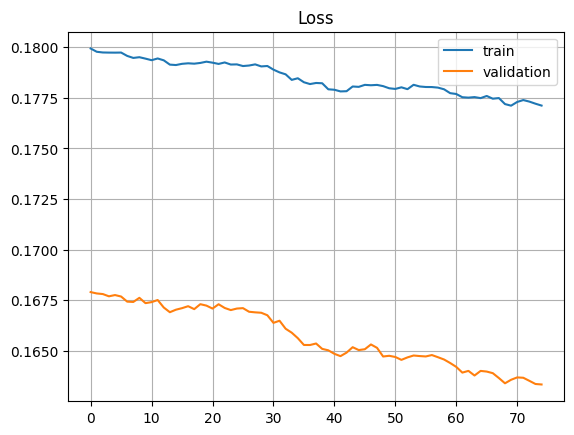

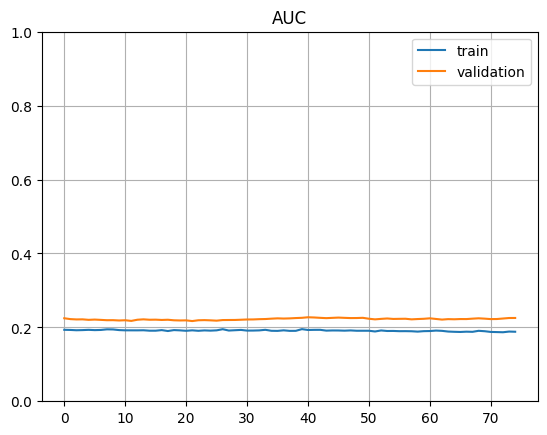

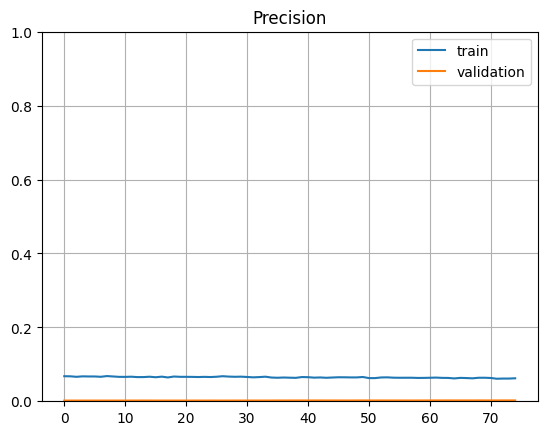

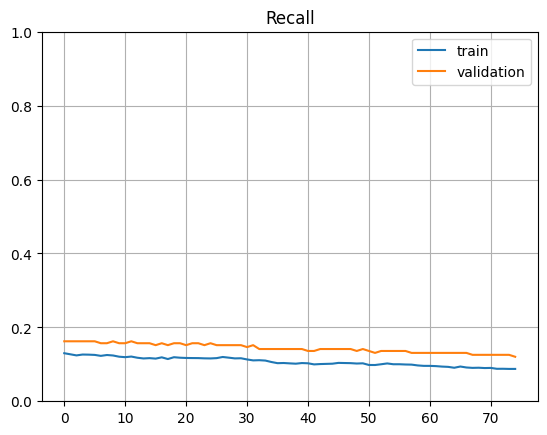

2380/2380 [==============================] - 9s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90     75668
           1       0.00      0.05      0.00       484

    accuracy                           0.82     76152
   macro avg       0.50      0.44      0.45     76152
weighted avg       0.99      0.82      0.90     76152

Confusion Matrix:


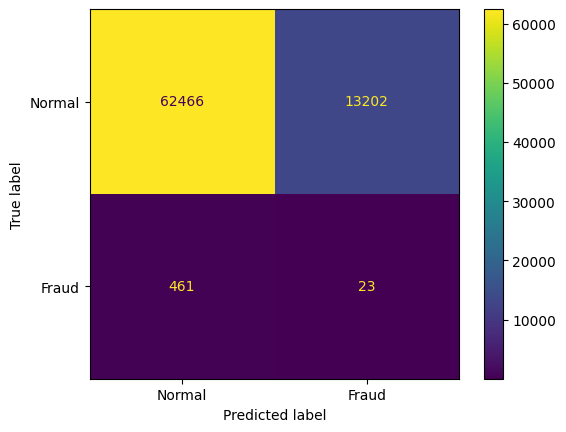

2380/2380 [==============================] - 8s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epsilon = 1.001, Delta = 1.0e-08


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


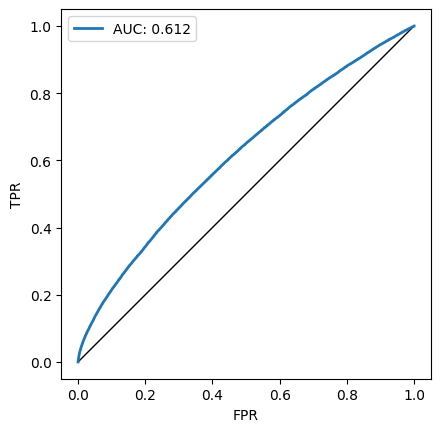

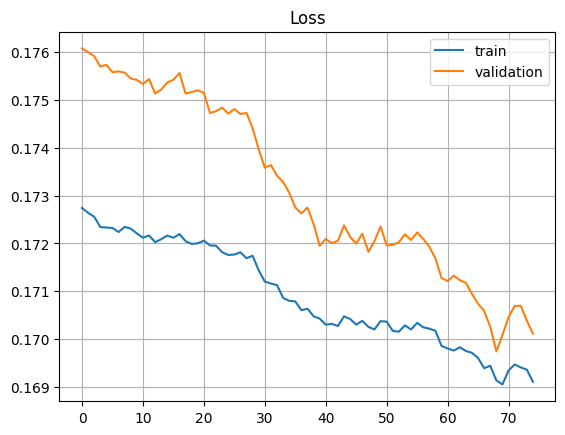

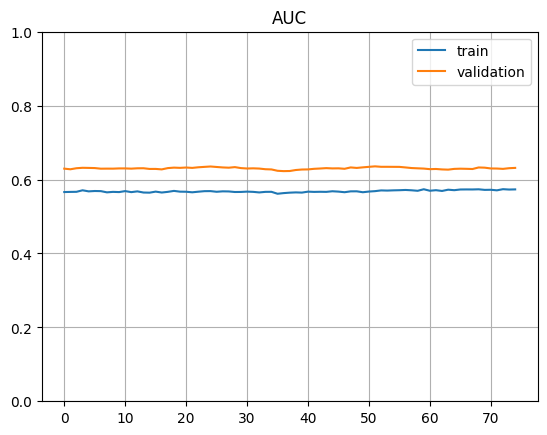

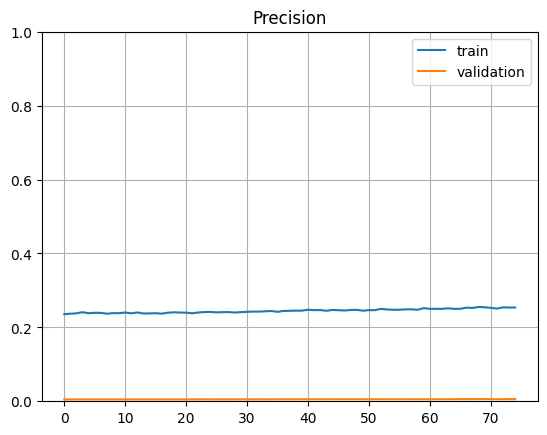

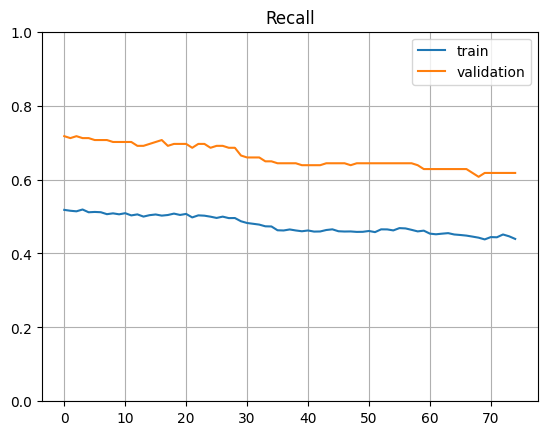

2380/2380 [==============================] - 8s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.61      0.76     75668
           1       0.01      0.53      0.02       484

    accuracy                           0.61     76152
   macro avg       0.50      0.57      0.39     76152
weighted avg       0.99      0.61      0.75     76152

Confusion Matrix:


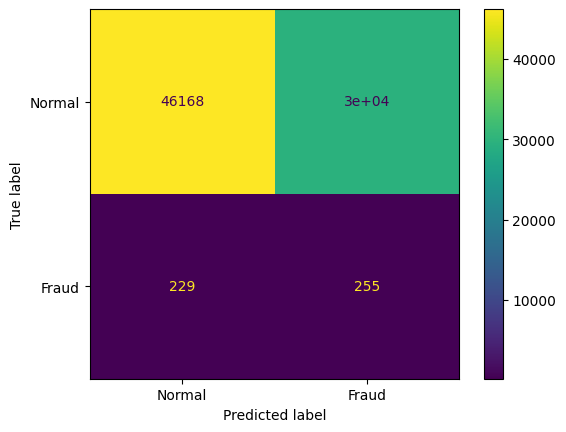

2380/2380 [==============================] - 8s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epsilon = 1.001, Delta = 1.0e-10


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


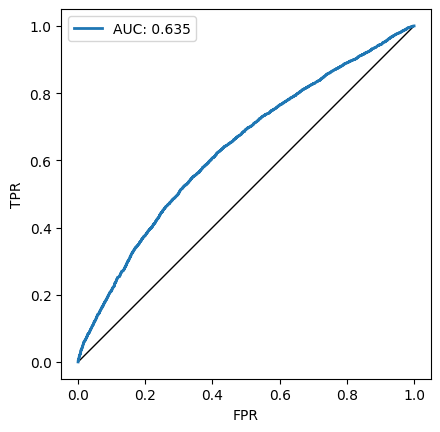

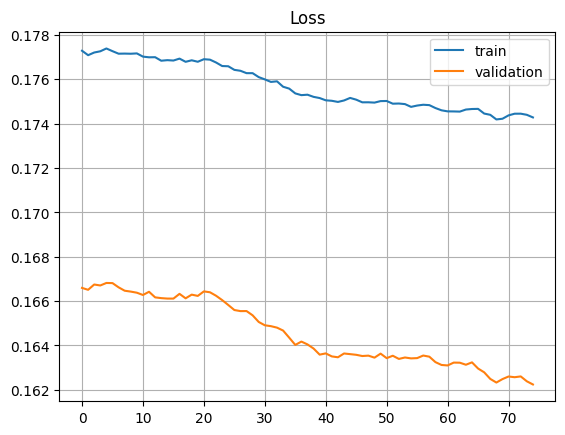

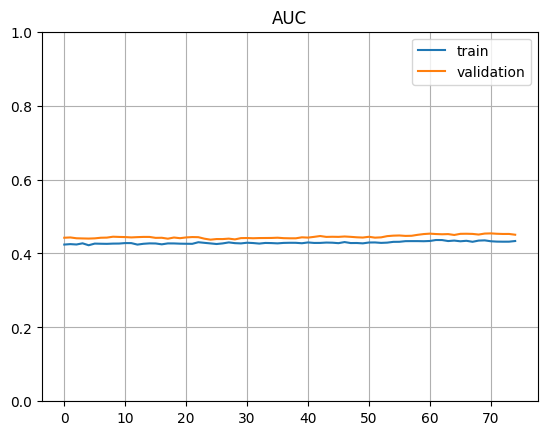

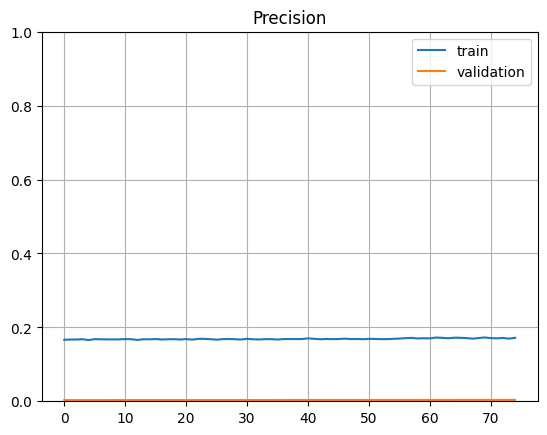

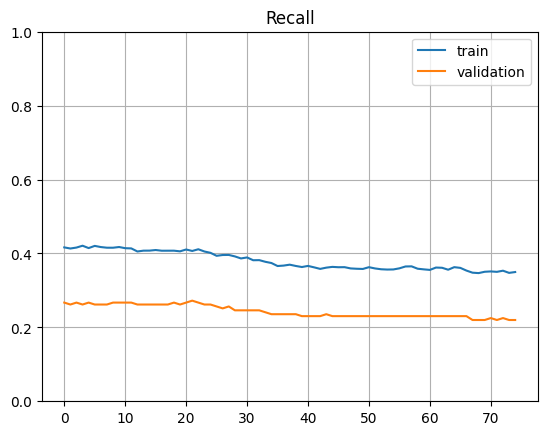

2380/2380 [==============================] - 8s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.80      0.89     75668
           1       0.00      0.14      0.01       484

    accuracy                           0.80     76152
   macro avg       0.50      0.47      0.45     76152
weighted avg       0.99      0.80      0.88     76152

Confusion Matrix:


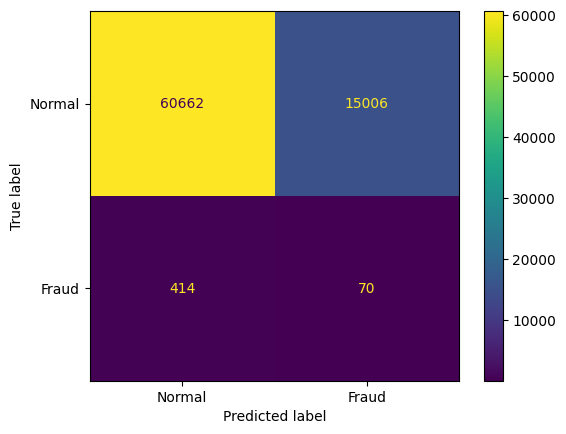

2380/2380 [==============================] - 7s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epsilon = 1.0, Delta = 1.0e-12


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


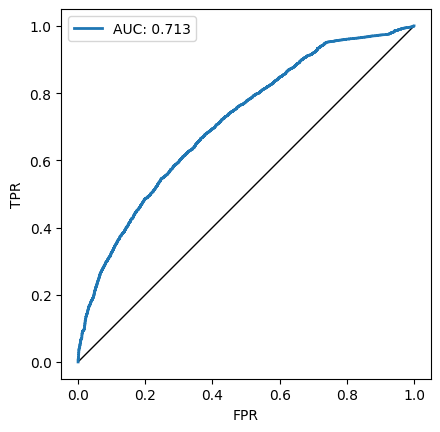

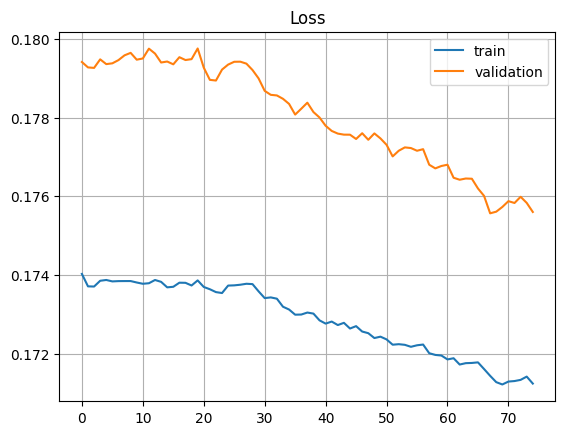

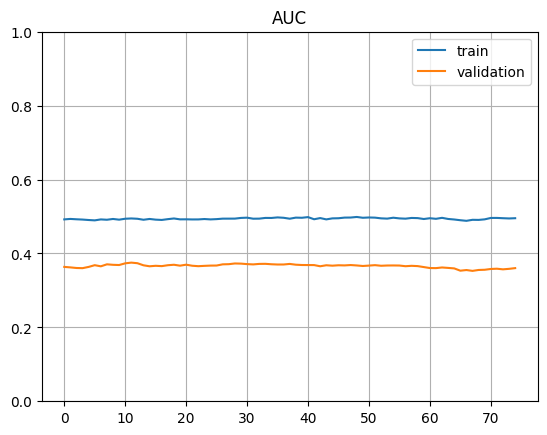

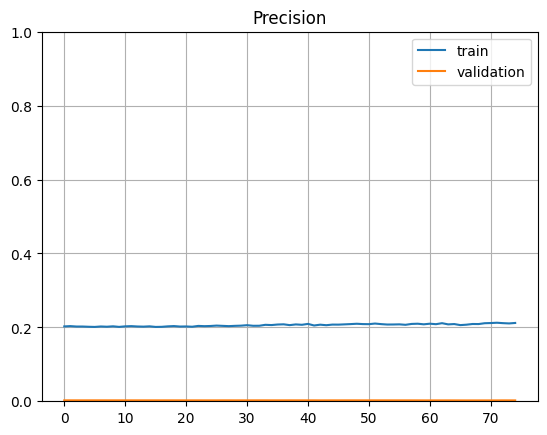

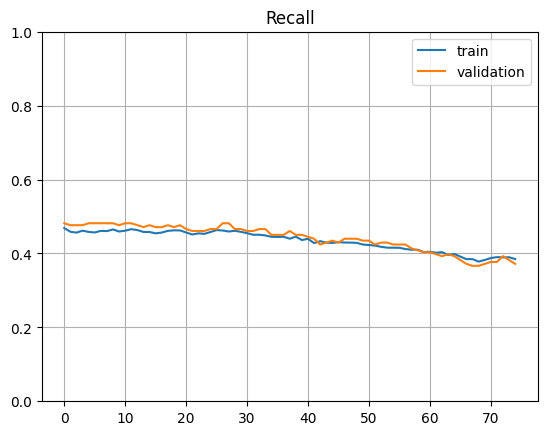

2380/2380 [==============================] - 8s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.39      0.56     75668
           1       0.00      0.40      0.01       484

    accuracy                           0.39     76152
   macro avg       0.50      0.40      0.29     76152
weighted avg       0.98      0.39      0.56     76152

Confusion Matrix:


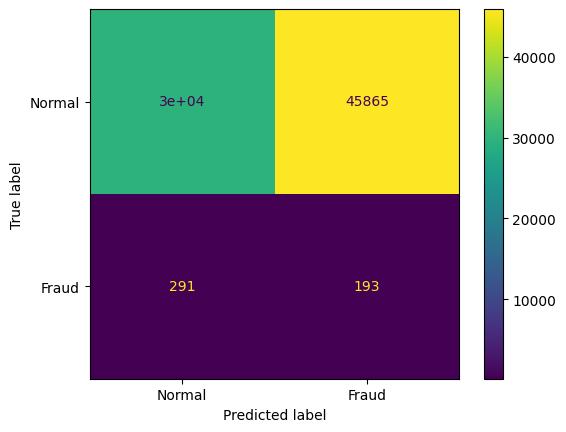

2380/2380 [==============================] - 8s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epsilon = 4.999, Delta = 1.0e-06


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


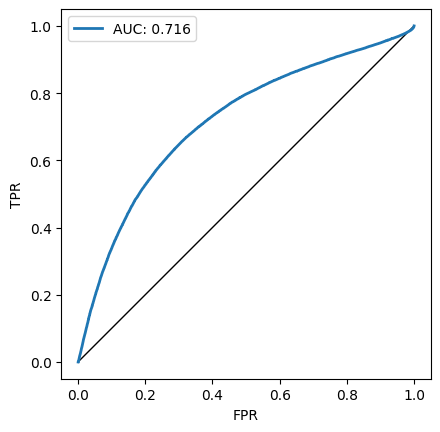

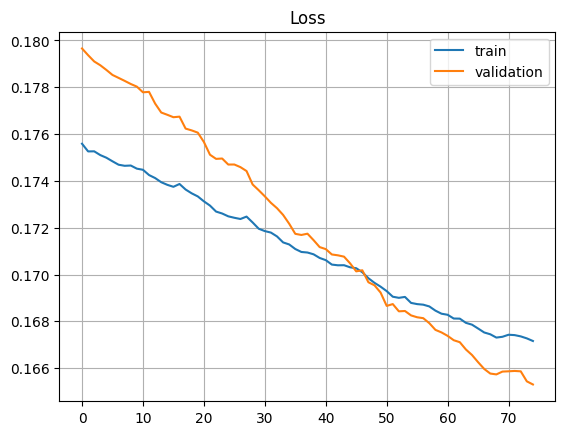

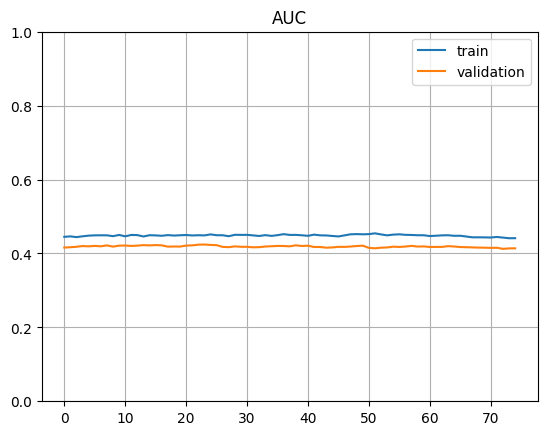

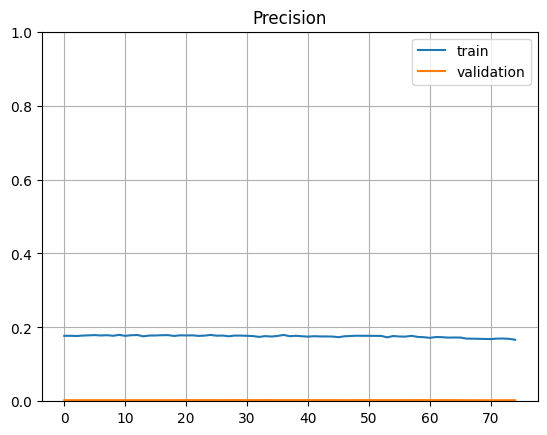

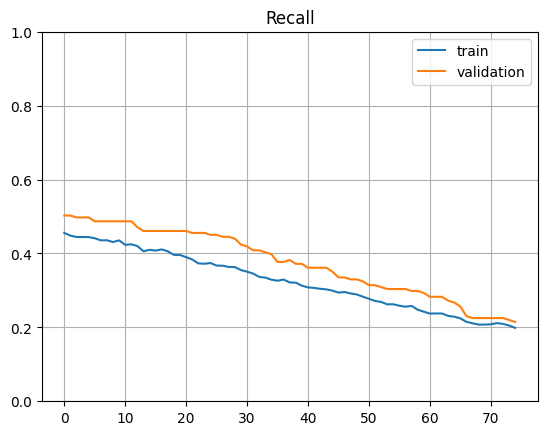

2380/2380 [==============================] - 9s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.69      0.81     75668
           1       0.01      0.30      0.01       484

    accuracy                           0.69     76152
   macro avg       0.50      0.49      0.41     76152
weighted avg       0.99      0.69      0.81     76152

Confusion Matrix:


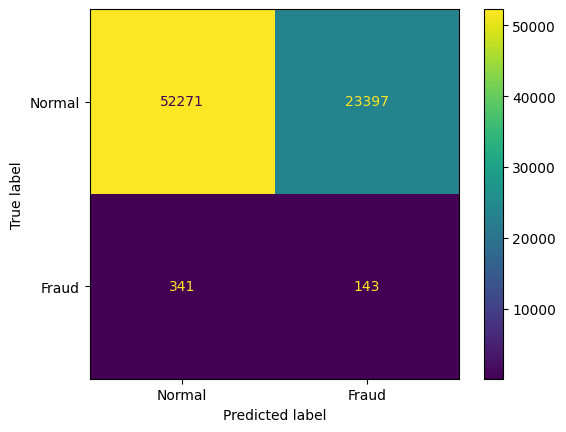

2380/2380 [==============================] - 7s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epsilon = 5.0, Delta = 1.0e-08


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


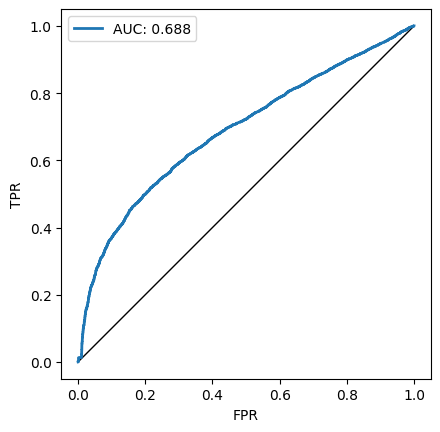

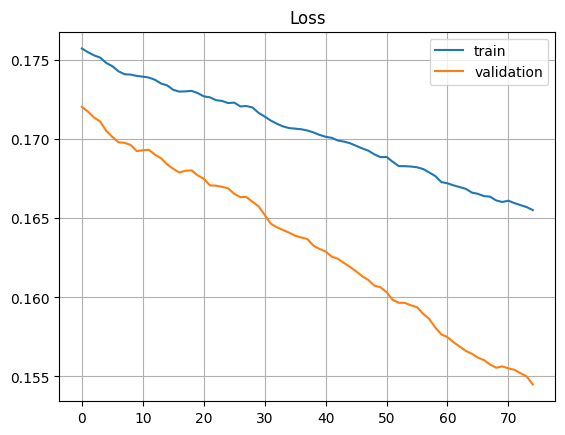

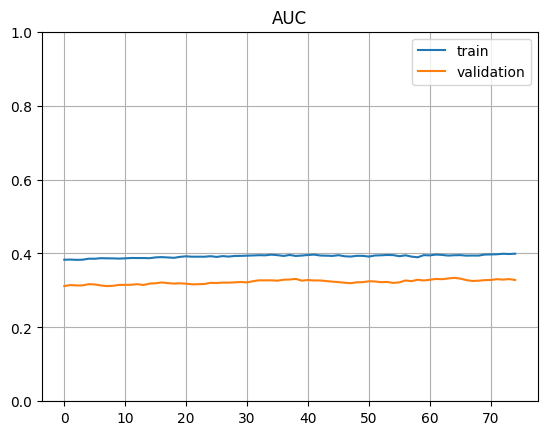

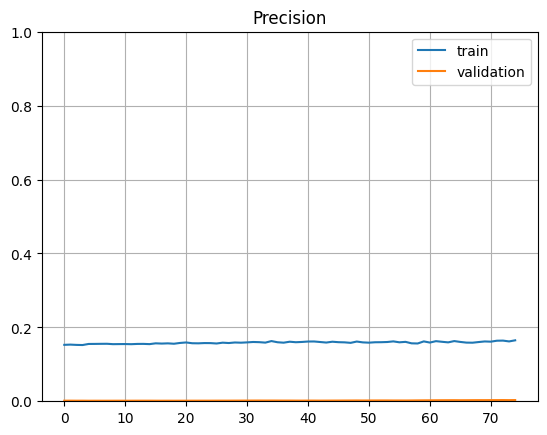

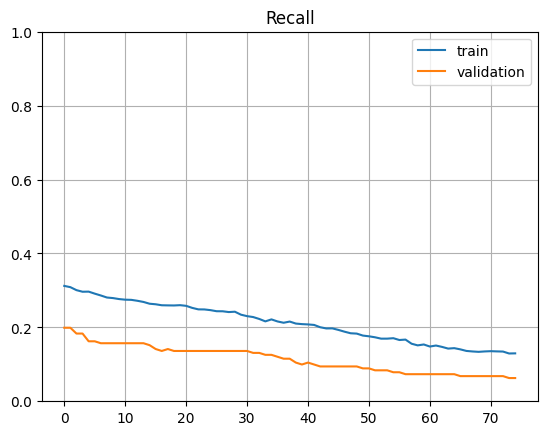

2380/2380 [==============================] - 9s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     75668
           1       0.00      0.02      0.01       484

    accuracy                           0.94     76152
   macro avg       0.50      0.49      0.49     76152
weighted avg       0.99      0.94      0.96     76152

Confusion Matrix:


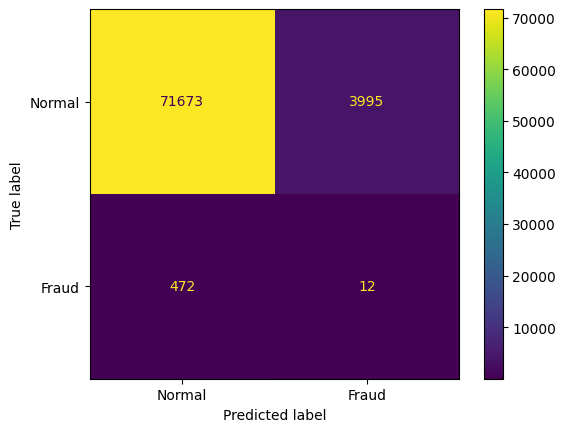

2380/2380 [==============================] - 8s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epsilon = 5.0, Delta = 1.0e-10


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


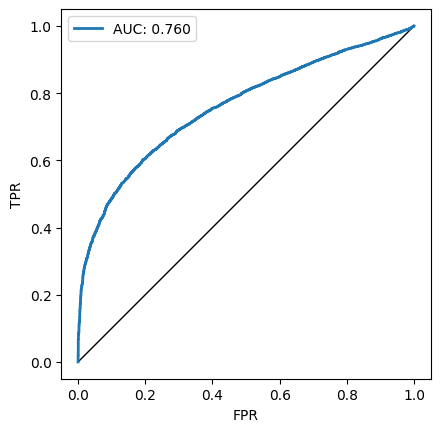

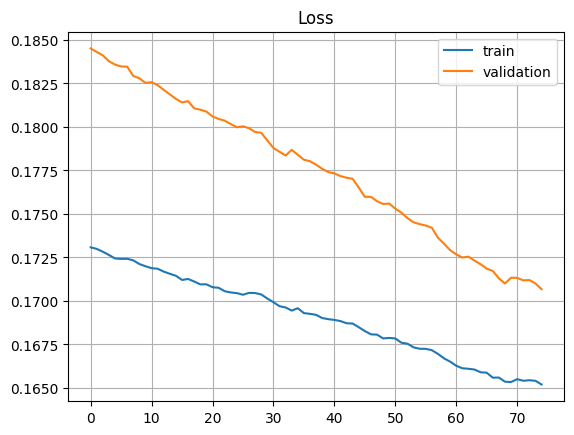

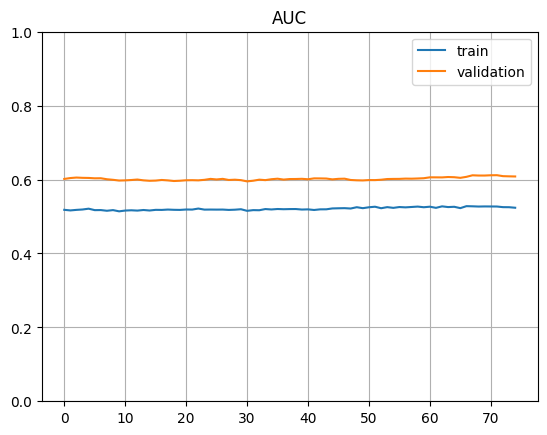

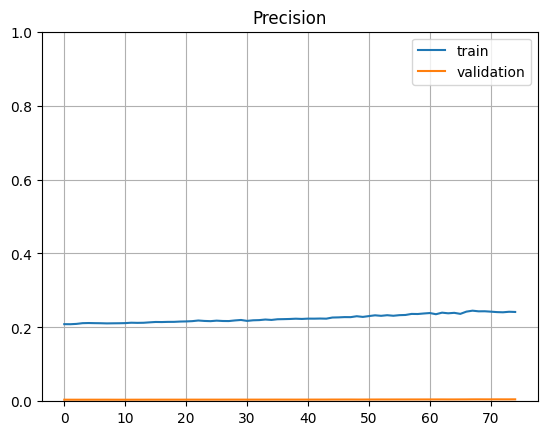

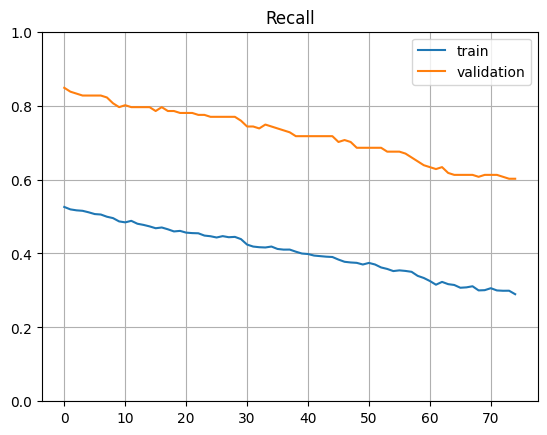

2380/2380 [==============================] - 9s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.58      0.74     75668
           1       0.01      0.56      0.02       484

    accuracy                           0.58     76152
   macro avg       0.50      0.57      0.38     76152
weighted avg       0.99      0.58      0.73     76152

Confusion Matrix:


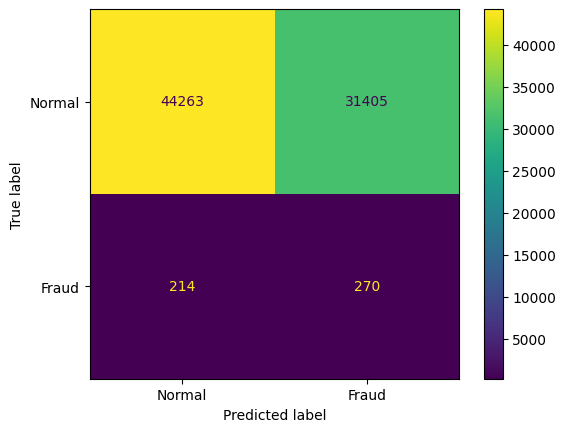

2380/2380 [==============================] - 8s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epsilon = 5.001, Delta = 1.0e-12


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


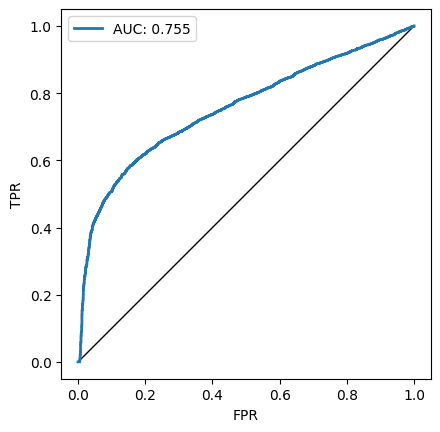

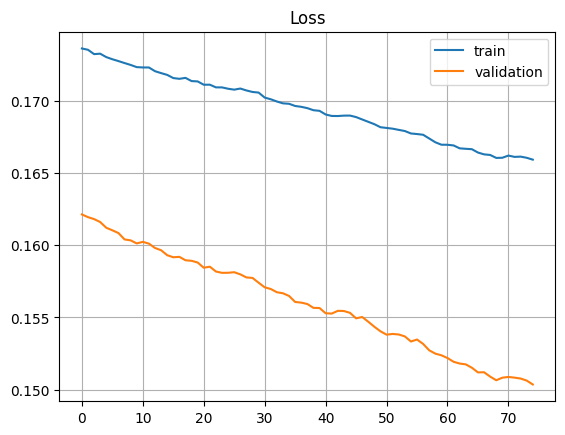

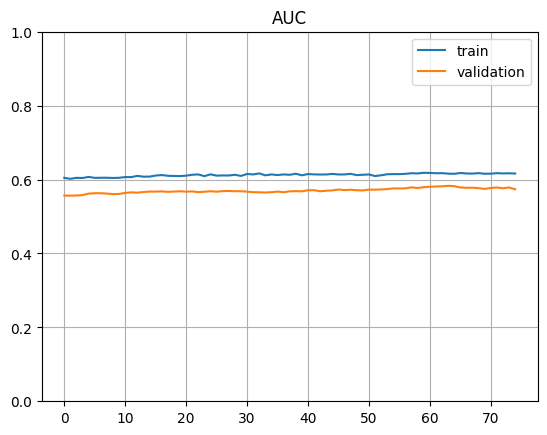

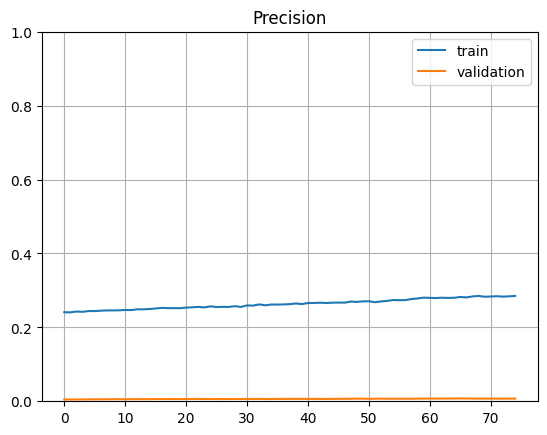

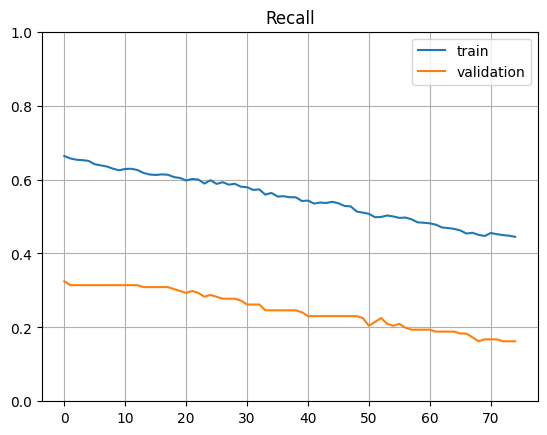

2380/2380 [==============================] - 8s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     75668
           1       0.01      0.16      0.02       484

    accuracy                           0.91     76152
   macro avg       0.50      0.53      0.49     76152
weighted avg       0.99      0.91      0.95     76152

Confusion Matrix:


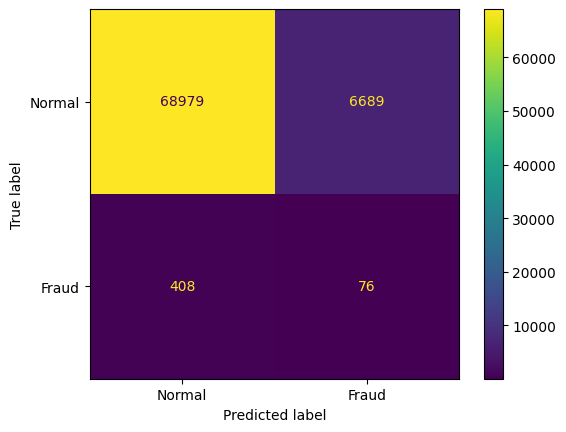

2380/2380 [==============================] - 8s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epsilon = 10.007, Delta = 1.0e-06


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


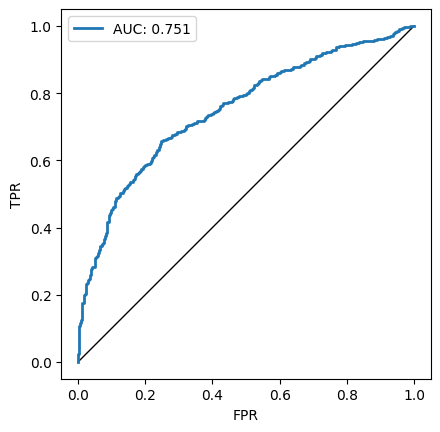

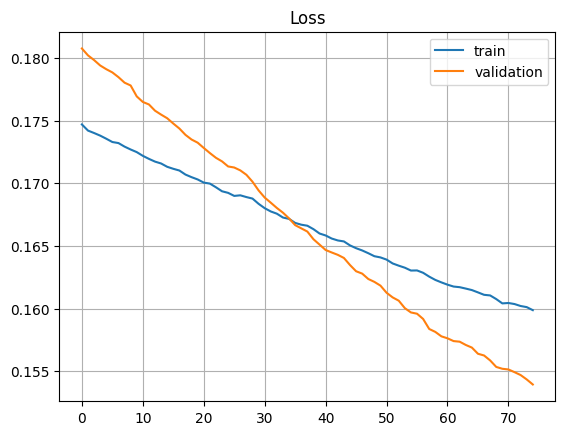

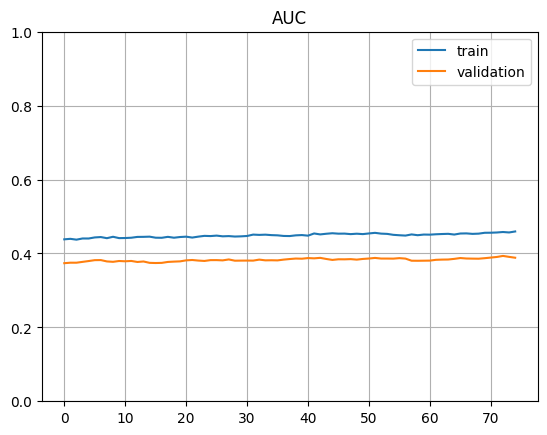

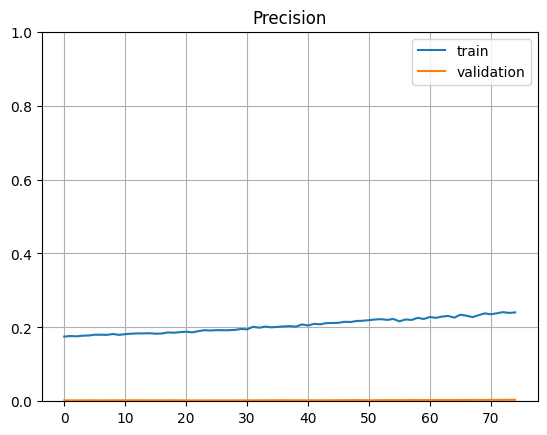

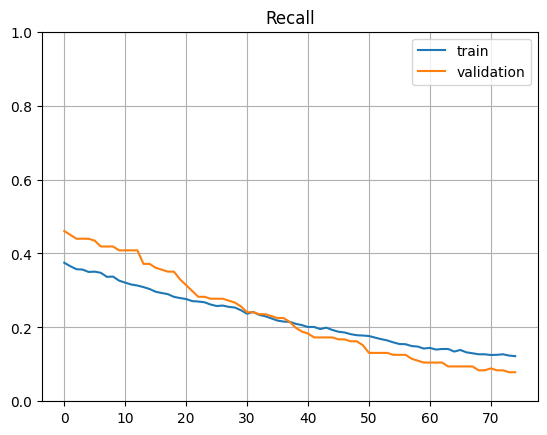

2380/2380 [==============================] - 9s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96     75668
           1       0.00      0.03      0.01       484

    accuracy                           0.93     76152
   macro avg       0.50      0.48      0.48     76152
weighted avg       0.99      0.93      0.96     76152

Confusion Matrix:


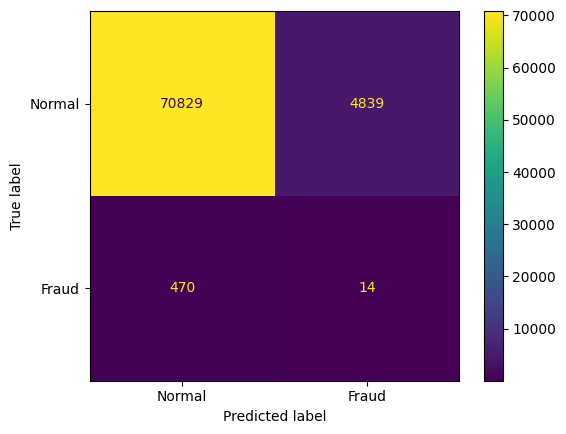

2380/2380 [==============================] - 7s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epsilon = 9.993, Delta = 1.0e-08


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


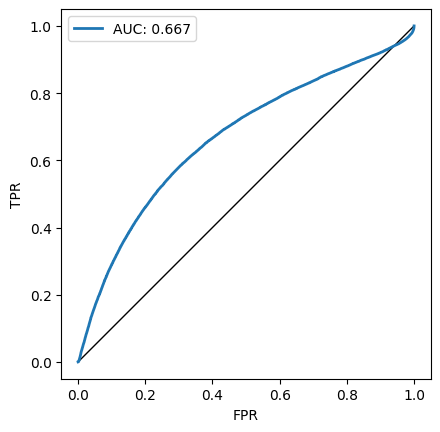

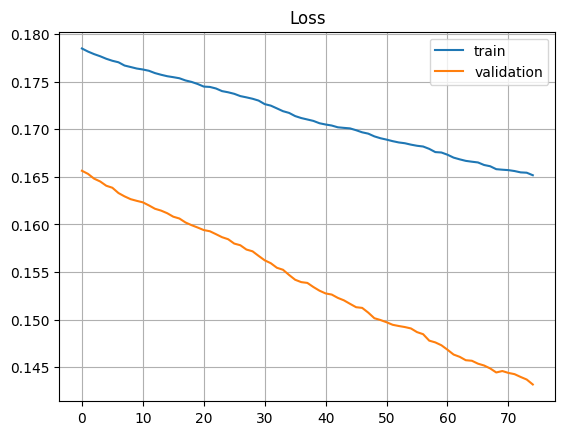

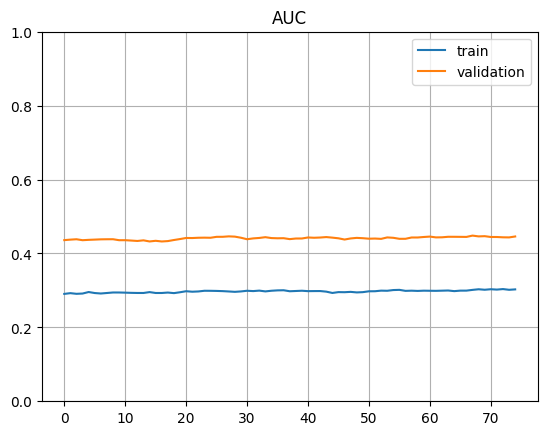

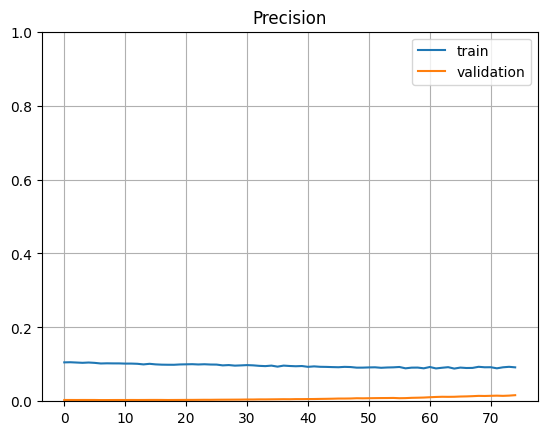

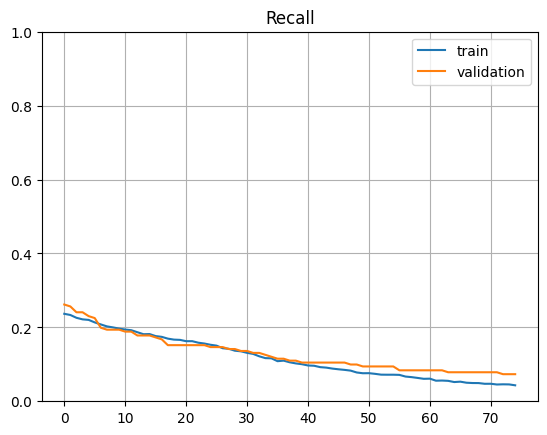

2380/2380 [==============================] - 9s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99     75668
           1       0.00      0.00      0.00       484

    accuracy                           0.98     76152
   macro avg       0.50      0.49      0.49     76152
weighted avg       0.99      0.98      0.98     76152

Confusion Matrix:


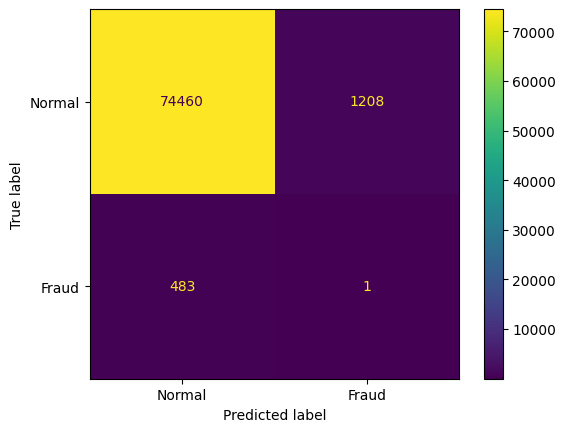

2380/2380 [==============================] - 8s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epsilon = 10.007, Delta = 1.0e-10


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


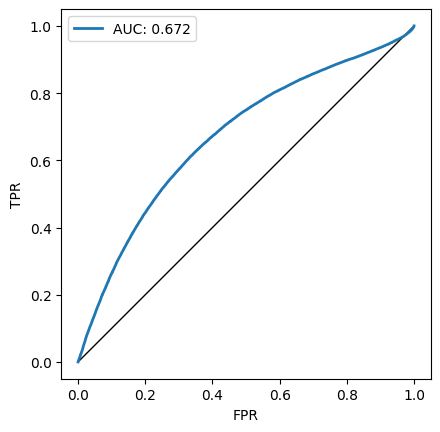

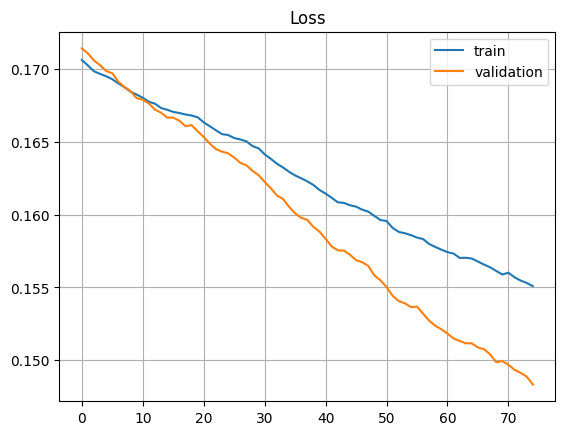

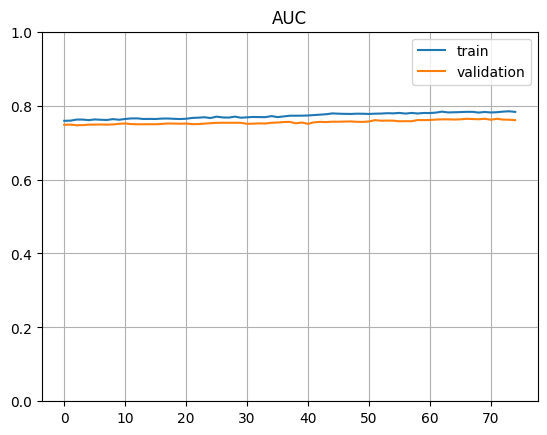

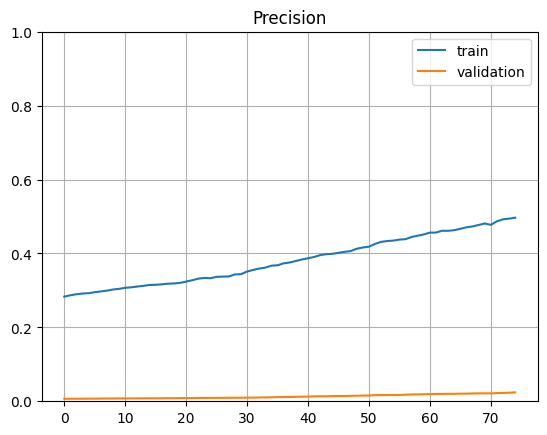

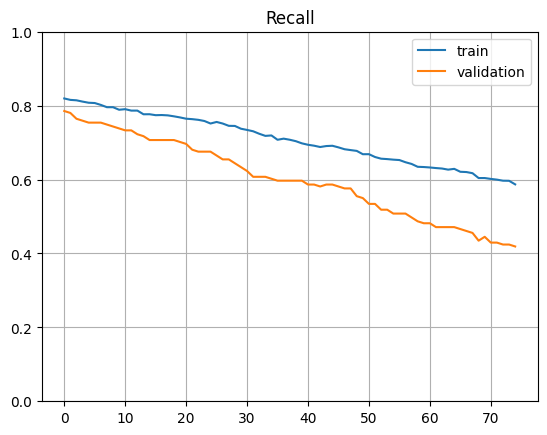

2380/2380 [==============================] - 9s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     75668
           1       0.04      0.38      0.07       484

    accuracy                           0.94     76152
   macro avg       0.52      0.66      0.52     76152
weighted avg       0.99      0.94      0.96     76152

Confusion Matrix:


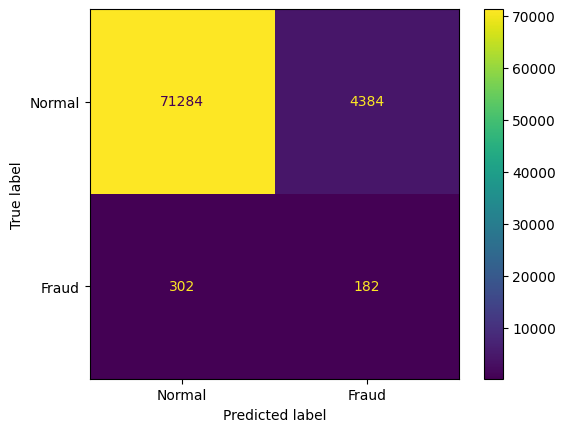

2380/2380 [==============================] - 8s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epsilon = 10.003, Delta = 1.0e-12


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


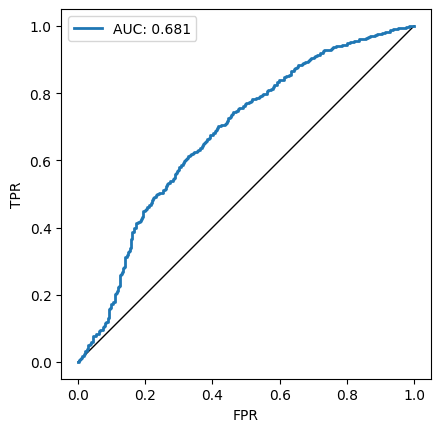

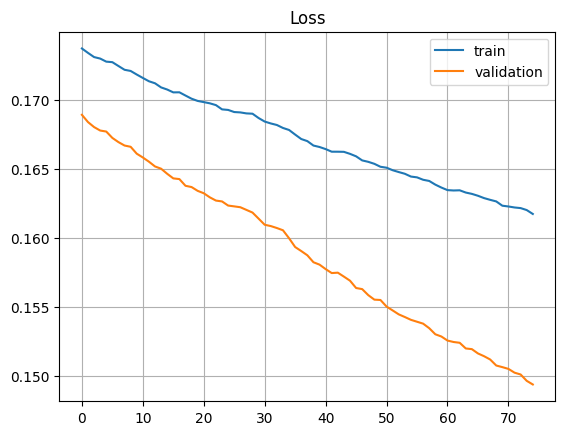

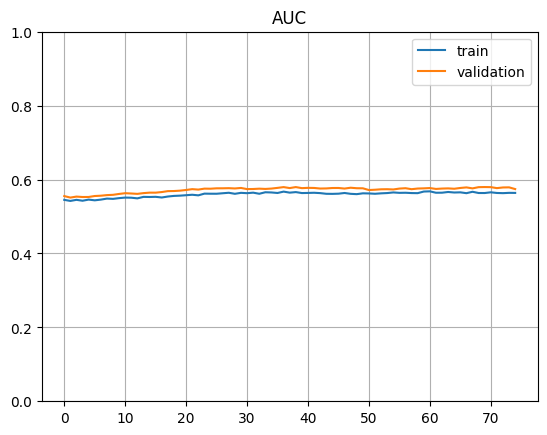

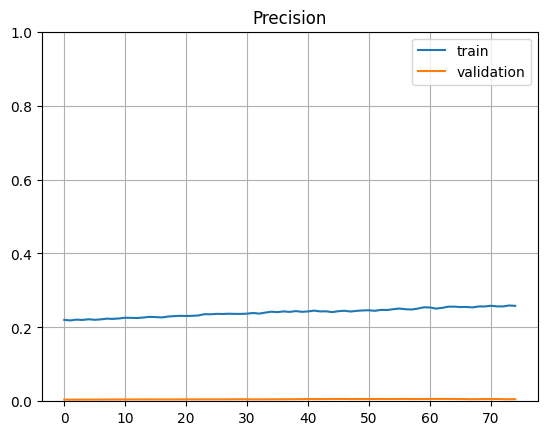

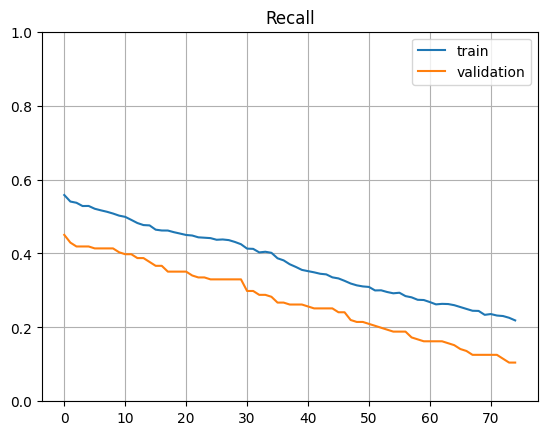

2380/2380 [==============================] - 9s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97     75668
           1       0.01      0.10      0.02       484

    accuracy                           0.94     76152
   macro avg       0.50      0.52      0.49     76152
weighted avg       0.99      0.94      0.96     76152

Confusion Matrix:


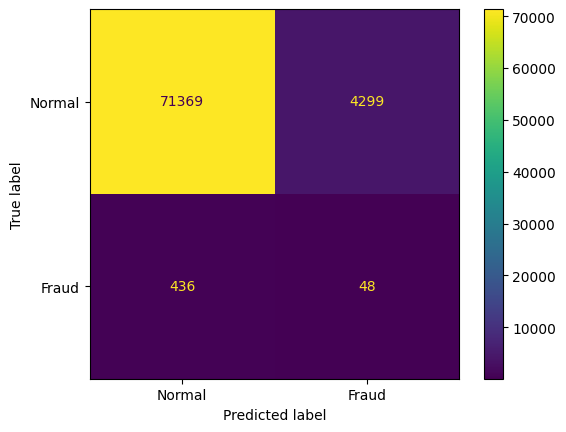

2380/2380 [==============================] - 7s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

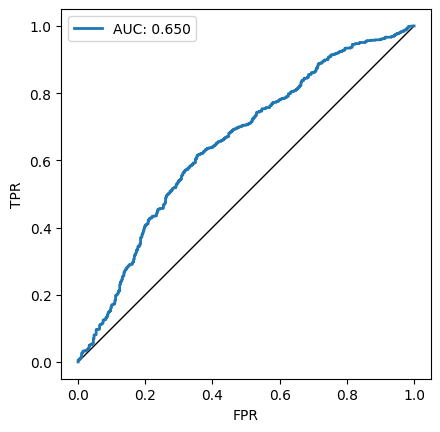

In [26]:
from services.eval_privacy import compute_mia_attacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

attacks_results_dict = {}
for eps, delta_results in results_per_eps.items():
    for delta, result in delta_results.items():
        model = result['model']
        history = result['history']

        print(f"Epsilon = {result['epsilon']}, Delta = {delta}")
        plt.figure()
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='validation')
        plt.title('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure()
        plt.plot(history.history['auc'], label='train')
        plt.plot(history.history['val_auc'], label='validation')
        plt.title('AUC')
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure()
        plt.plot(history.history['precision'], label='train')
        plt.plot(history.history['val_precision'], label='validation')
        plt.title('Precision')
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure()
        plt.plot(history.history['recall'], label='train')
        plt.plot(history.history['val_recall'], label='validation')
        plt.title('Recall')
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.show()

        y_pred = model.predict(X_test_seq)
        print("Classification Report:")
        print(classification_report(y_test_seq, y_pred > 0.5))

        # Create a confusion matrix
        conf_matrix = confusion_matrix(y_test_seq, y_pred > 0.5)
        print("Confusion Matrix:")
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Fraud'])
        disp.plot()
        plt.show()

        n_rows = X_test_seq.shape[0]
        attacks_result, figure = compute_mia_attacks(model, X_train_seq[:n_rows], X_test_seq, y_train_seq[:n_rows], y_test_seq)  
        if eps not in attacks_results_dict:
            attacks_results_dict[eps] = {}
        attacks_results_dict[eps][delta] = attacks_result

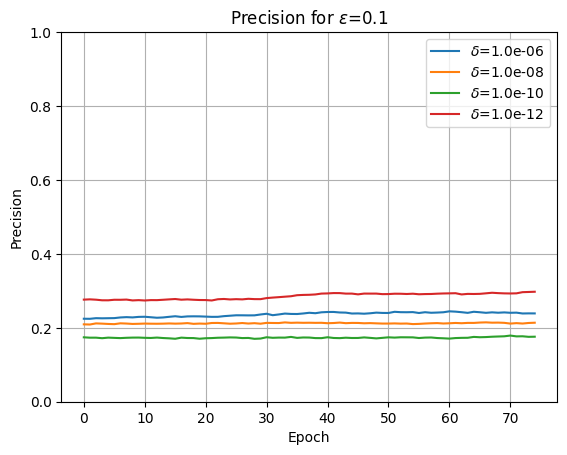

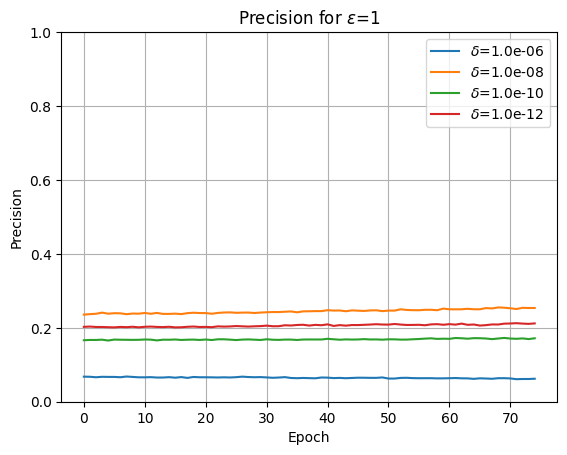

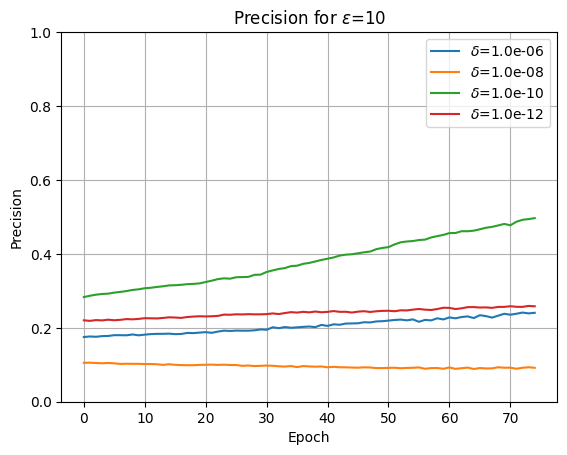

In [123]:
epsilons = [0.1, 1, 10]
for eps in epsilons:
    plt.figure()
    for delta, result in results_per_eps[eps].items():
        model = result['model']
        history = result['history']
        plt.plot(history.history['precision'], label=f'$\delta$={delta}')
    plt.title(f'Precision for $\epsilon$={eps}')
    plt.legend()
    plt.ylim(0, 1)
    plt.grid(True)
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.show()

In [ ]:
from services.eval_privacy import compute_mia_attacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

attacks_results_dict = {}
for eps, delta_results in results_per_eps.items():
    for delta, result in delta_results.items():
        model = result['model']
        history = result['history']

        print(f"Epsilon = {result['epsilon']}, Delta = {delta}")
        plt.figure()
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='validation')
        plt.title('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure()
        plt.plot(history.history['auc'], label='train')
        plt.plot(history.history['val_auc'], label='validation')
        plt.title('AUC')
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure()
        plt.plot(history.history['precision'], label='train')
        plt.plot(history.history['val_precision'], label='validation')
        plt.title('Precision')
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.show()

        plt.figure()
        plt.plot(history.history['recall'], label='train')
        plt.plot(history.history['val_recall'], label='validation')
        plt.title('Recall')
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.show()

        y_pred = model.predict(X_test_seq)
        print("Classification Report:")
        print(classification_report(y_test_seq, y_pred > 0.5))

        # Create a confusion matrix
        conf_matrix = confusion_matrix(y_test_seq, y_pred > 0.5)
        print("Confusion Matrix:")
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Fraud'])
        disp.plot()
        plt.show()

        n_rows = X_test_seq.shape[0]
        attacks_result, figure = compute_mia_attacks(model, X_train_seq[:n_rows], X_test_seq, y_train_seq[:n_rows], y_test_seq)  
        if eps not in attacks_results_dict:
            attacks_results_dict[eps] = {}
        attacks_results_dict[eps][delta] = attacks_result

2380/2380 [==============================] - 8s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

2380/2380 [==============================] - 8s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

2380/2380 [==============================] - 9s 4ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

2380/2380 [==============================] - 9s 4ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

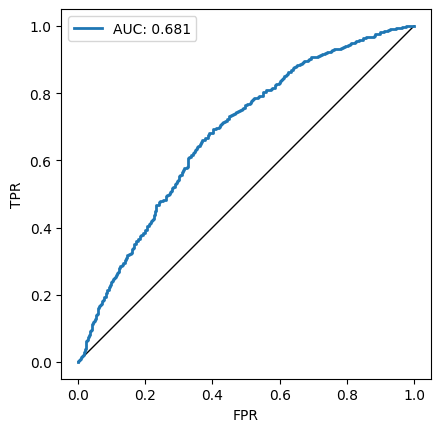

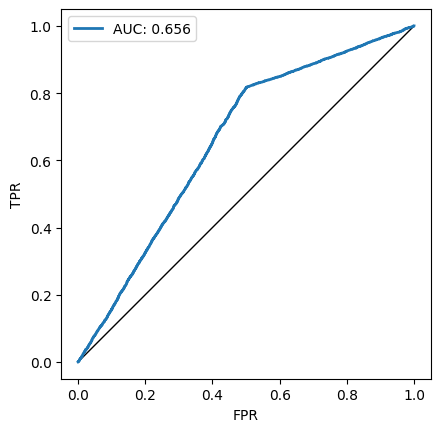

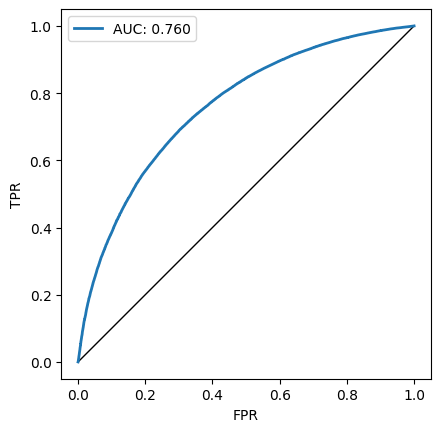

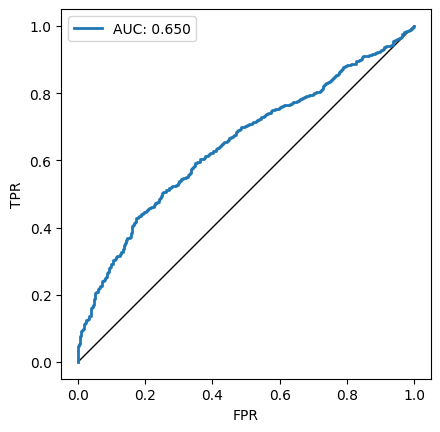

In [98]:
eps = 0.1
for delta, result in results_per_eps[eps].items():
    model = result['model']

    n_rows = X_test_seq.shape[0]
    attacks_result, figure = compute_mia_attacks(model, X_train_seq, X_test_seq, y_train_seq, y_test_seq)
    if eps not in attacks_results_dict:
        attacks_results_dict[eps] = {}
    attacks_results_dict[eps][delta] = attacks_result

2380/2380 [==============================] - 8s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

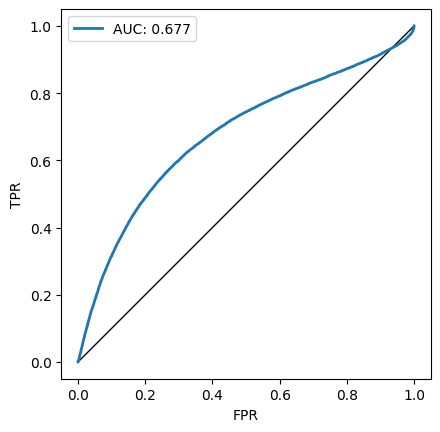

In [61]:
eps = 1
for delta, result in results_per_eps[eps].items():
    model = result['model']

    n_rows = X_test_seq.shape[0]
    attacks_result, figure = compute_mia_attacks(model, X_train_seq[:n_rows], X_test_seq, y_train_seq[:n_rows], y_test_seq)
    if eps not in attacks_results_dict:
        attacks_results_dict[eps] = {}
    attacks_results_dict[eps][delta] = attacks_result

2380/2380 [==============================] - 9s 4ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

2380/2380 [==============================] - 8s 4ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

2380/2380 [==============================] - 8s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

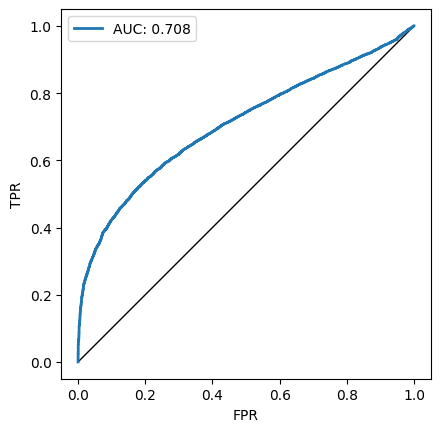

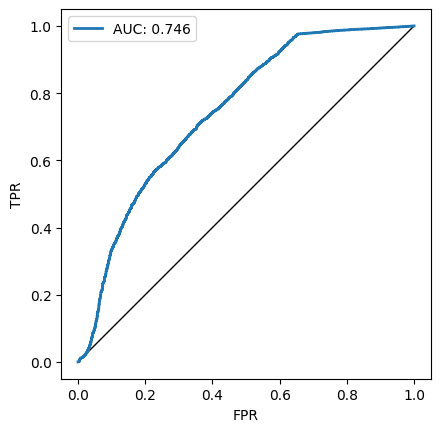

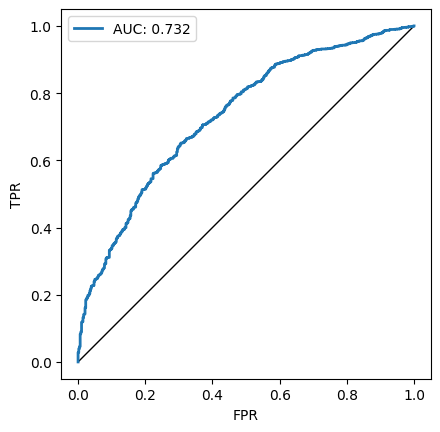

In [83]:
eps = 5
for delta, result in results_per_eps[eps].items():
    model = result['model']

    n_rows = X_test_seq.shape[0]
    attacks_result, figure = compute_mia_attacks(model, X_train_seq[:2*n_rows], X_test_seq, y_train_seq[:2*n_rows], y_test_seq)  
    if eps not in attacks_results_dict:
        attacks_results_dict[eps] = {}
    attacks_results_dict[eps][delta] = attacks_result

In [11]:
eps = 10
for delta, result in delta_results[eps].items():
    model = result['model']

    n_rows = X_test_seq.shape[0]
    attacks_result, figure = compute_mia_attacks(model, X_train_seq[:n_rows], X_test_seq, y_train_seq[:n_rows], y_test_seq)  
    if eps not in attacks_results_dict:
        attacks_results_dict[eps] = {}
    attacks_results_dict[eps][delta] = attacks_result

KeyError: 10

In [109]:
attacks_results_pkl = {}
for eps, delta_attacks_results_dict in attacks_results_dict.items():
    for delta, attack_result in delta_attacks_results_dict.items():
        if eps not in attacks_results_pkl:
            attacks_results_pkl[eps] = {}
        attacks_results_pkl[eps][delta] = attack_result.get_result_with_max_auc()

In [ ]:
hist_results_pkl = {}
for eps, delta_results in results_per_eps.items():
    if eps not in hist_results_pkl:
        hist_results_pkl[eps] = {}
    for delta, result in delta_results.items():
        history = result['history']
        hist_results_pkl[eps][delta] = history.history

with open('results/dp_lstm/hist_results_per_eps_delta.pkl', 'wb') as f:
    pickle.dump(hist_results_pkl, f)

In [ ]:
for eps, delta_results in results_per_eps.items():
    for delta, result in delta_results.items():
        model = result['model']
        model.save(f'results/dp_lstm/lstm_models/lstm_model_eps_{eps}_delta_{delta}.h5')

c:\Users\Albert Salles\anaconda3\envs\ds\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [111]:
import pickle

with open('results/dp_lstm/dp_results_per_eps_delta.pkl', 'wb') as f: 
    pickle.dump(attacks_results_pkl, f)

In [100]:
baseline_attack_results = pickle.load(open('model/varying_dataset_sizes/attacks_results.pkl', 'rb'))

In [33]:
attacks_results_pkl = pickle.load(open('results/dp_results_per_eps_delta.pkl', 'rb'))

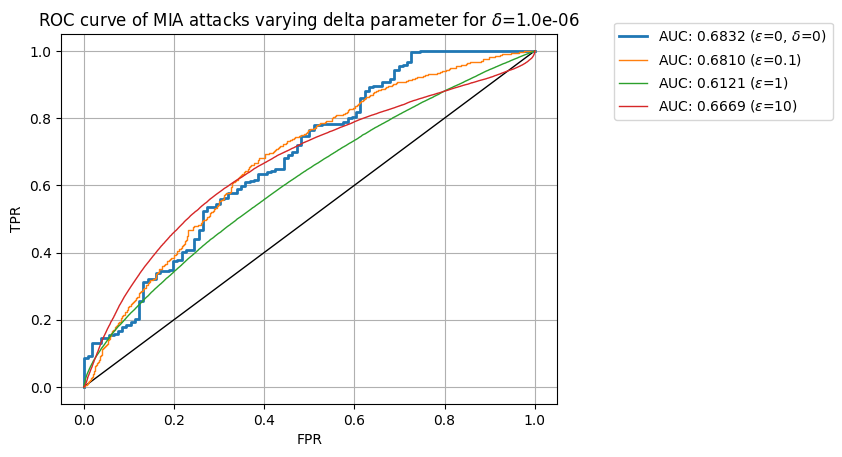

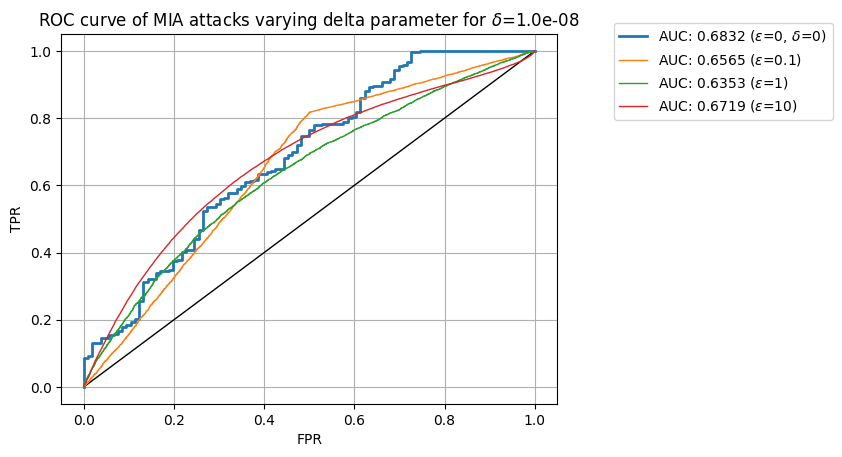

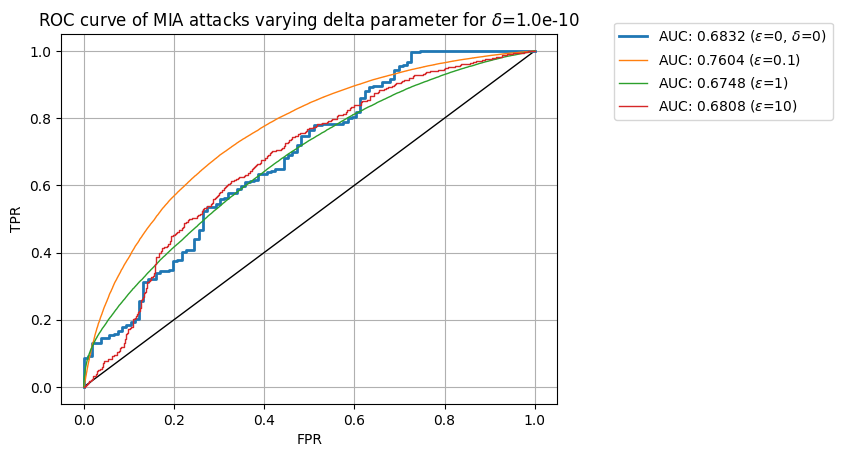

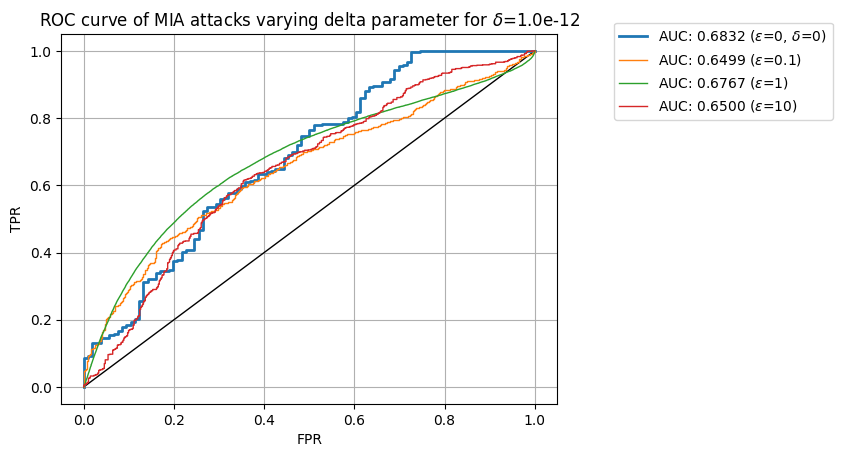

In [130]:
from sklearn import metrics

for delta in attacks_results_dict[1]: 
    fig = plt.figure()
    plt.plot([0, 1], [0, 1], 'k', lw=1.0)
    x_baseline = baseline_attack_results[9].roc_curve.fpr
    y_baseline = baseline_attack_results[9].roc_curve.tpr
    auc_baseline = metrics.auc(x_baseline, y_baseline)
    plt.plot(x_baseline, y_baseline, lw=2, label=f'AUC: {auc_baseline:.4f} ($\epsilon$=0, $\delta$=0)')
    for eps in attacks_results_dict:
        if eps == 5:
            continue
        x = attacks_results_dict[eps][delta].get_result_with_max_auc().roc_curve.fpr
        y = attacks_results_dict[eps][delta].get_result_with_max_auc().roc_curve.tpr
        auc = metrics.auc(x, y)
        plt.plot(x, y, lw=1, label=f'AUC: {auc:.4f} ($\epsilon$={eps})')
    plt.title(f'ROC curve of MIA attacks varying delta parameter for $\delta$={delta}')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

In [100]:
from services.dp_modeling import train_model_with_delta

best_hp['num_microbatches'] = 1
best_hp['l2_norm_clip'] = 1.0
best_hp['learning_rate'] = 0.00001

eps_values = [0.25, 0.5, 0.75] 

delta = 1e-6*10

for eps in eps_values:
    print(f"δ={delta:.1e}")
    print(f"ε={eps}")
    if eps not in results_per_eps:
        results_per_eps[eps] = {}
    results_per_eps[eps][delta] = train_model_with_delta(delta, X_train, y_train, X_val, y_val, best_hp, target_epsilon=float(eps), epochs=50, batch_size=32)


δ=1.0e-05
ε=0.25
δ=1.0e-05: Using noise_multiplier=102.811 (Achieved ε=0.25)
Train shape: (195317, 5, 29)
Val shape: (50779, 5, 29)
Class balance: (array([0, 1]), array([156254,  39063], dtype=int64))
Epoch 1/50
6104/6104 [==============================] - 202s 23ms/step - loss: 0.1728 - accuracy: 0.5330 - precision: 0.1931 - recall: 0.4198 - auc: 0.4800 - val_loss: 0.1836 - val_accuracy: 0.3256 - val_precision: 0.0023 - val_recall: 0.4136 - val_auc: 0.3287
Epoch 2/50
6104/6104 [==============================] - 139s 23ms/step - loss: 0.1727 - accuracy: 0.5347 - precision: 0.1914 - recall: 0.4115 - auc: 0.4765 - val_loss: 0.1831 - val_accuracy: 0.3333 - val_precision: 0.0023 - val_recall: 0.4031 - val_auc: 0.3327
Epoch 3/50
6104/6104 [==============================] - 157s 26ms/step - loss: 0.1727 - accuracy: 0.5361 - precision: 0.1917 - recall: 0.4104 - auc: 0.4748 - val_loss: 0.1835 - val_accuracy: 0.3291 - val_precision: 0.0024 - val_recall: 0.4188 - val_auc: 0.3375
Epoch 4/50
6104/

Epsilon = 10.005, Eps = 10


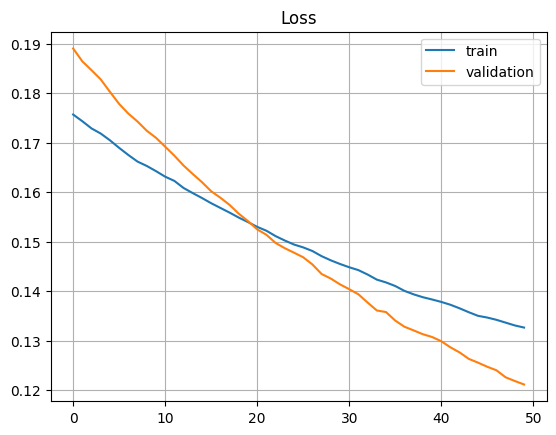

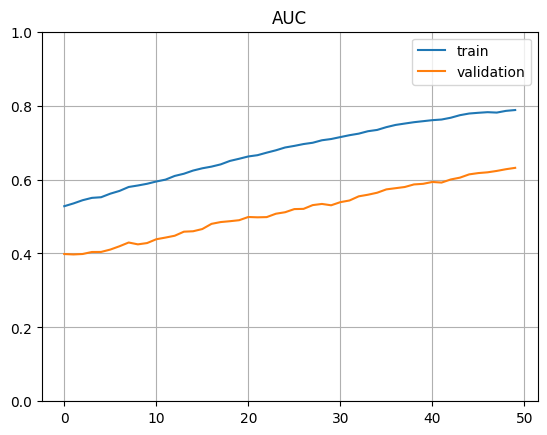

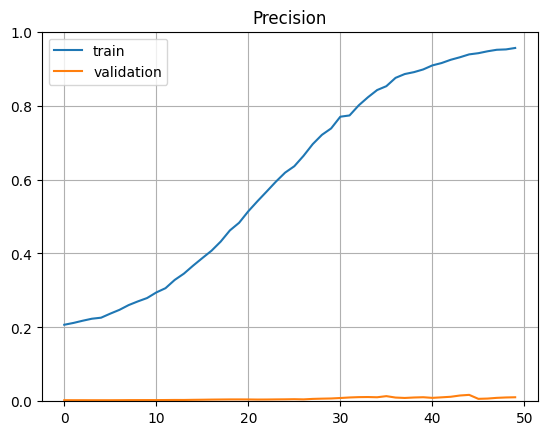

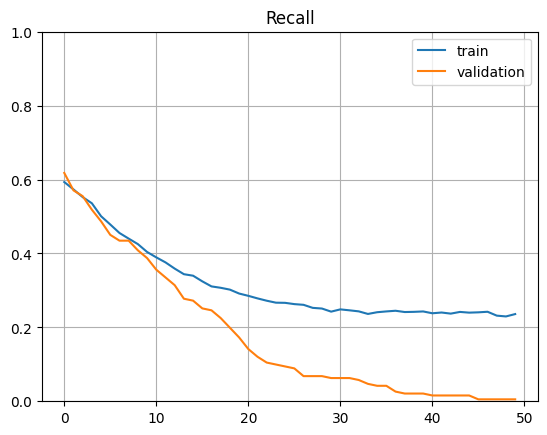

2380/2380 [==============================] - 11s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     75668
           1       0.25      0.05      0.09       484

    accuracy                           0.99     76152
   macro avg       0.62      0.53      0.54     76152
weighted avg       0.99      0.99      0.99     76152

Confusion Matrix:


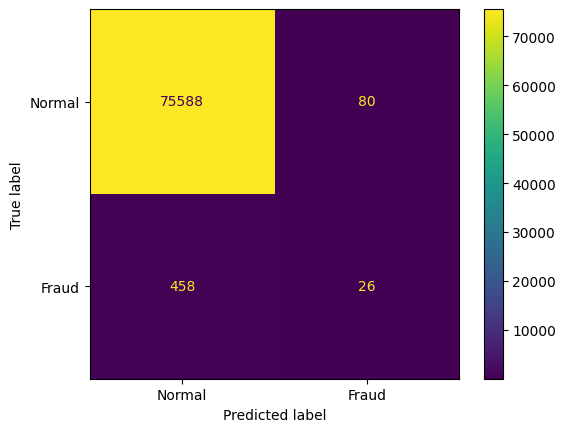

2380/2380 [==============================] - 9s 4ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epsilon = 5.002, Eps = 5


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


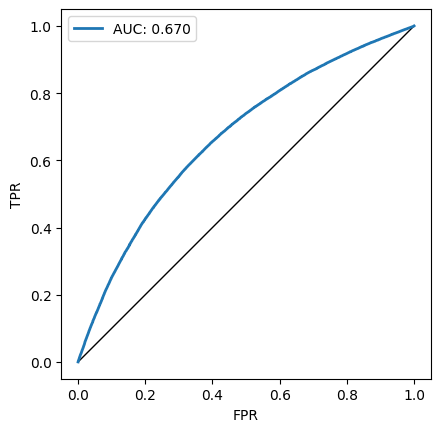

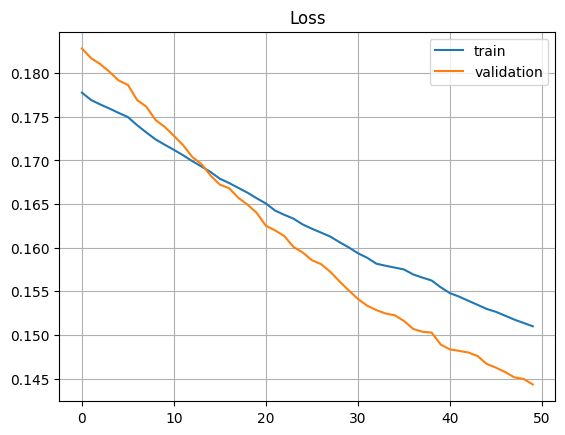

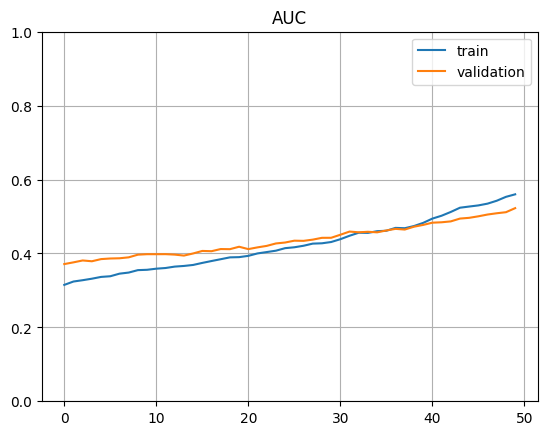

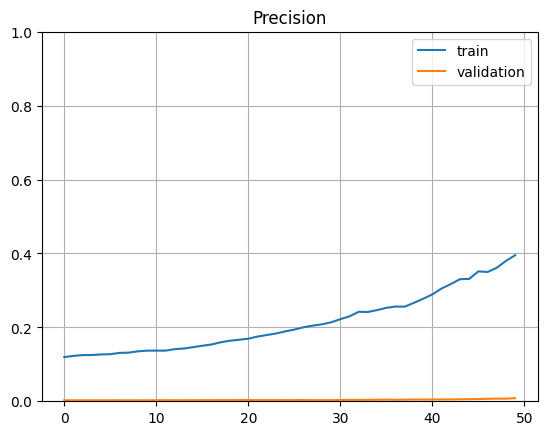

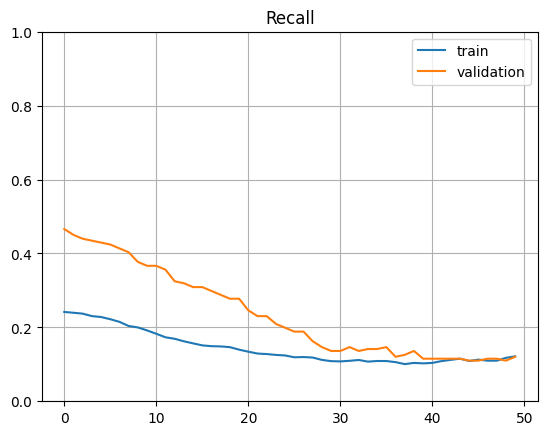

2380/2380 [==============================] - 9s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97     75668
           1       0.01      0.10      0.02       484

    accuracy                           0.94     76152
   macro avg       0.50      0.52      0.49     76152
weighted avg       0.99      0.94      0.96     76152

Confusion Matrix:


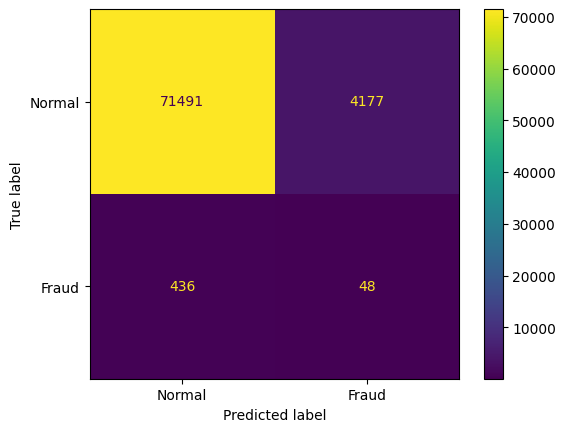

2380/2380 [==============================] - 8s 4ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epsilon = 0.1, Eps = 0.1


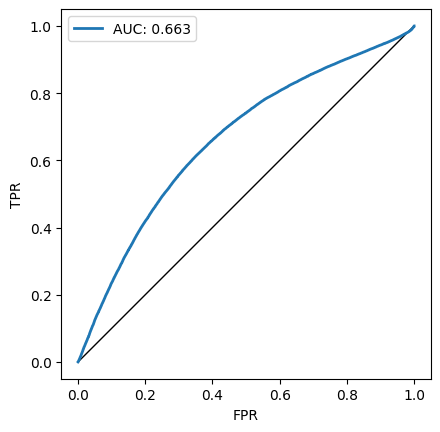

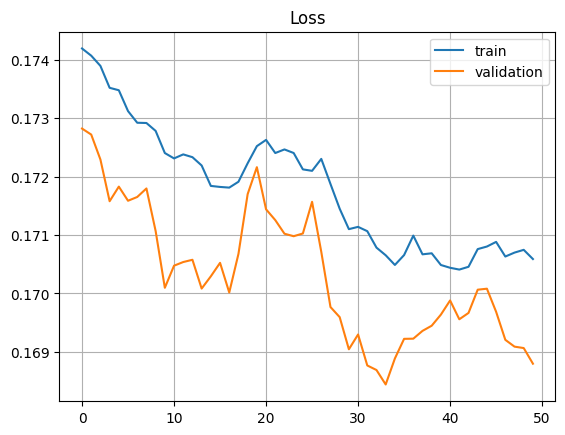

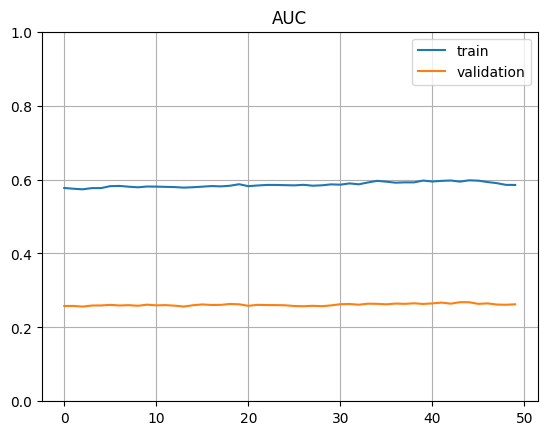

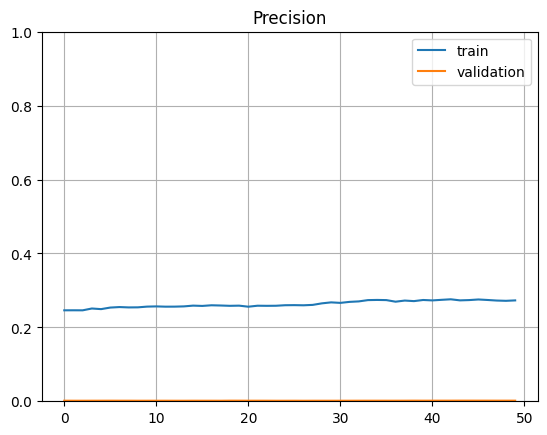

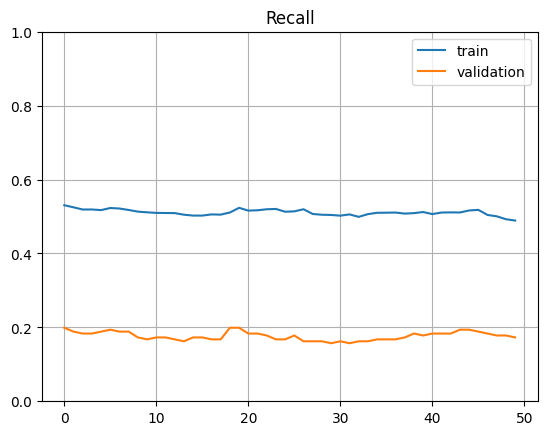

2380/2380 [==============================] - 15s 6ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.56      0.72     75668
           1       0.00      0.20      0.01       484

    accuracy                           0.56     76152
   macro avg       0.50      0.38      0.36     76152
weighted avg       0.98      0.56      0.71     76152

Confusion Matrix:


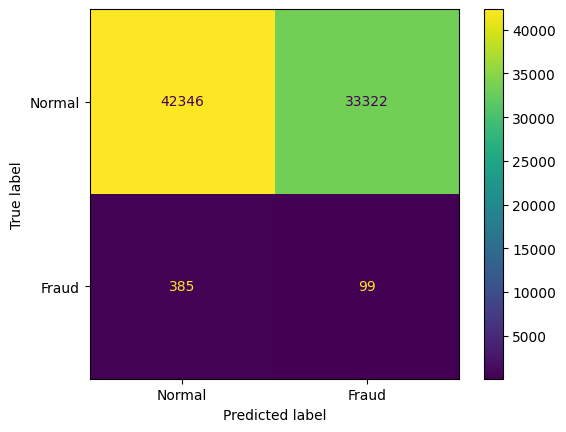

2380/2380 [==============================] - 10s 4ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epsilon = 1.001, Eps = 1


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


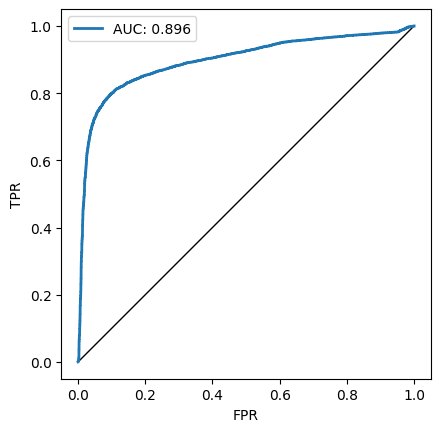

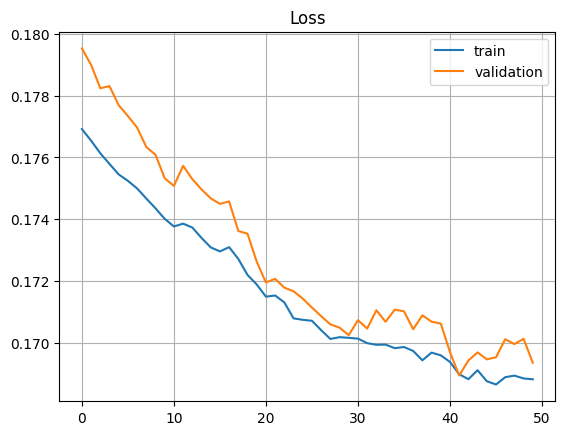

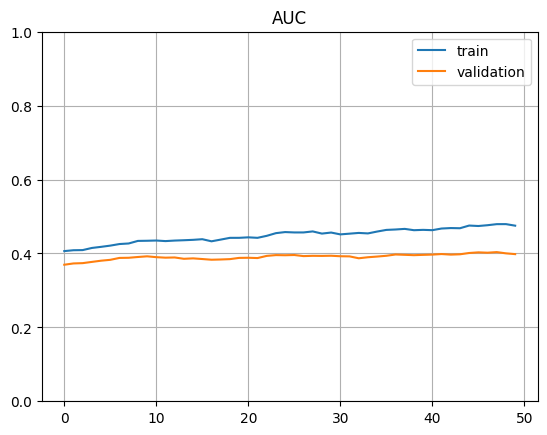

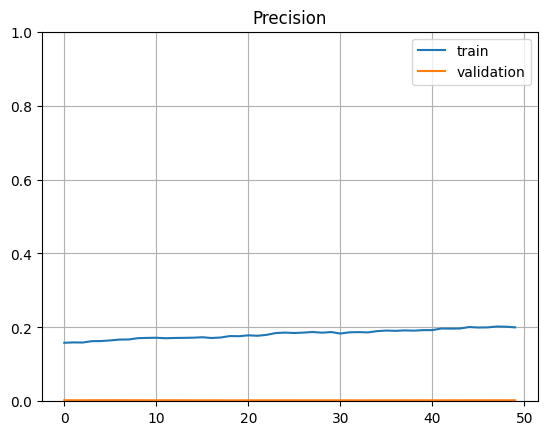

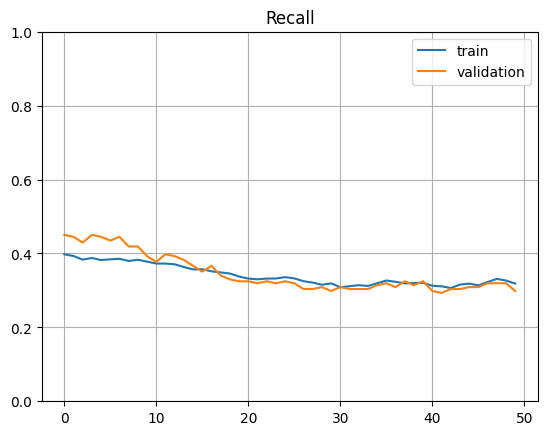

2380/2380 [==============================] - 9s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.58      0.73     75668
           1       0.01      0.40      0.01       484

    accuracy                           0.58     76152
   macro avg       0.50      0.49      0.37     76152
weighted avg       0.99      0.58      0.73     76152

Confusion Matrix:


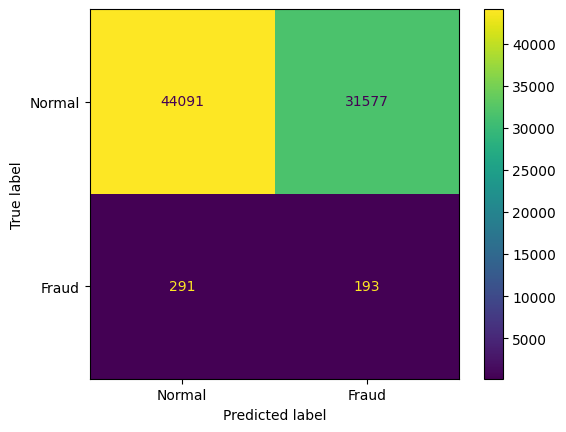

2380/2380 [==============================] - 10s 4ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epsilon = 50.194, Eps = 50


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


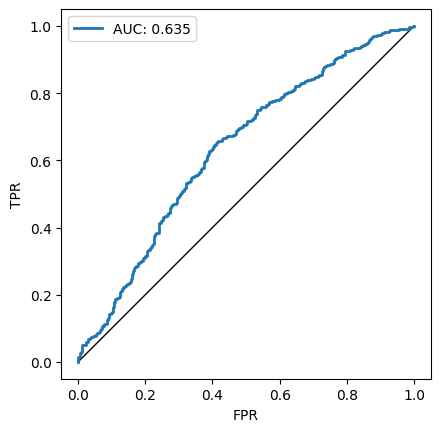

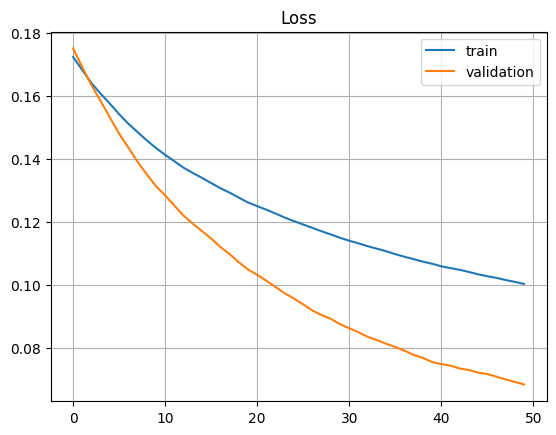

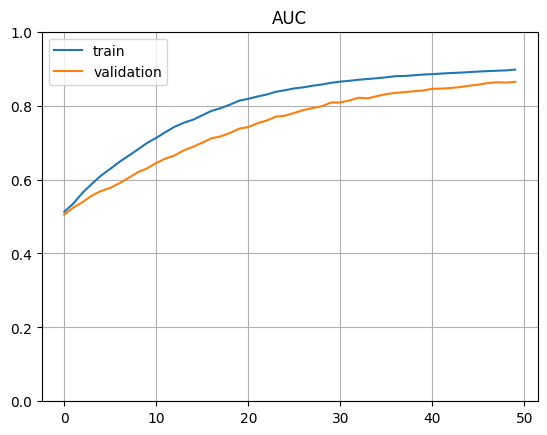

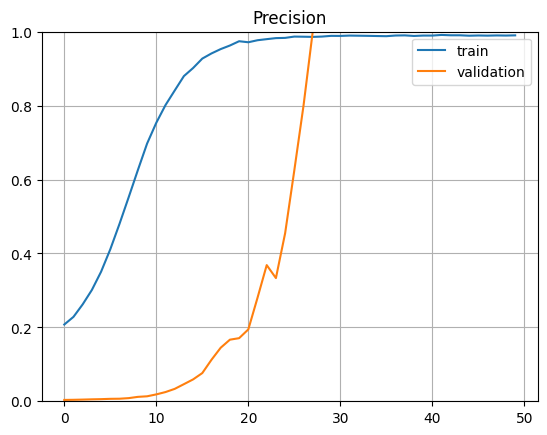

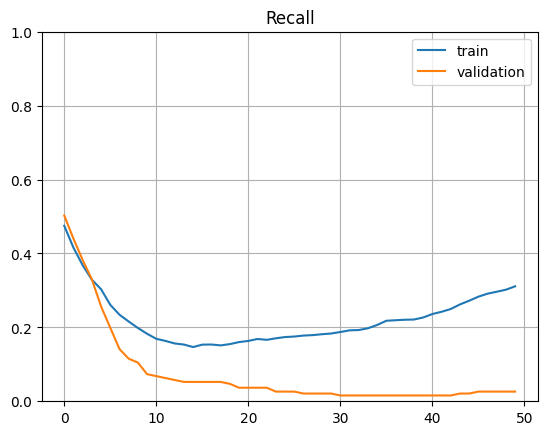

2380/2380 [==============================] - 10s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     75668
           1       1.00      0.03      0.06       484

    accuracy                           0.99     76152
   macro avg       1.00      0.52      0.53     76152
weighted avg       0.99      0.99      0.99     76152

Confusion Matrix:


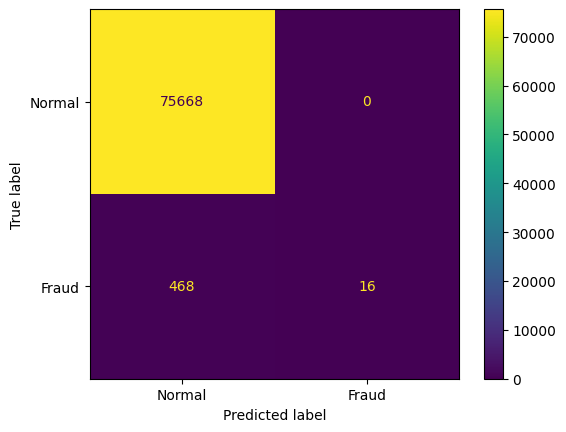

2380/2380 [==============================] - 11s 5ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epsilon = 99.549, Eps = 100


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


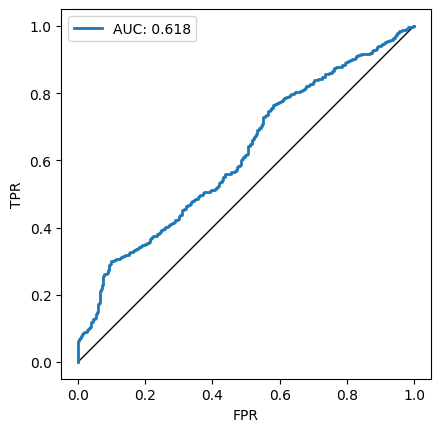

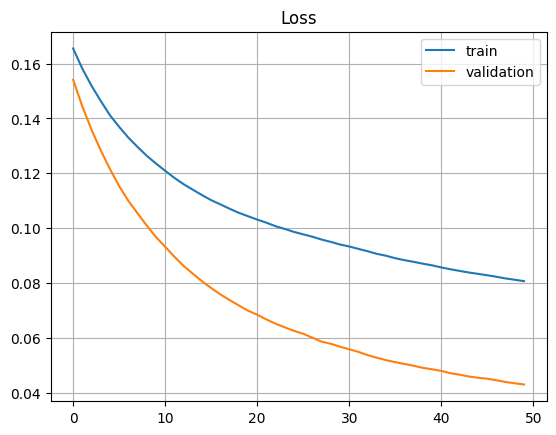

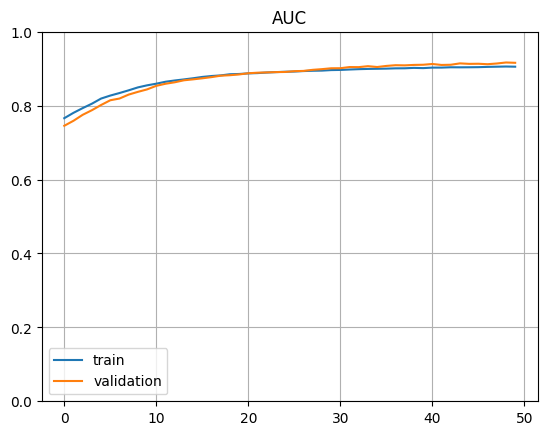

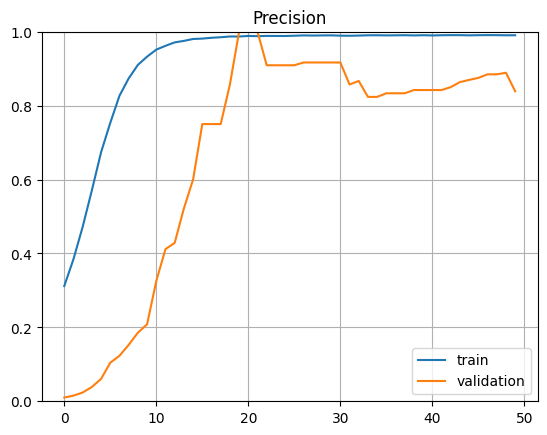

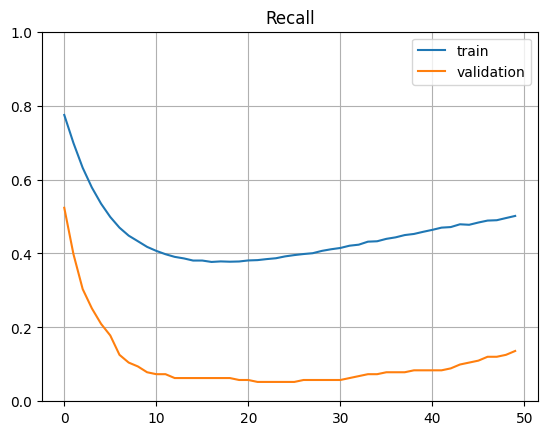

2380/2380 [==============================] - 11s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75668
           1       1.00      0.26      0.42       484

    accuracy                           1.00     76152
   macro avg       1.00      0.63      0.71     76152
weighted avg       1.00      1.00      0.99     76152

Confusion Matrix:


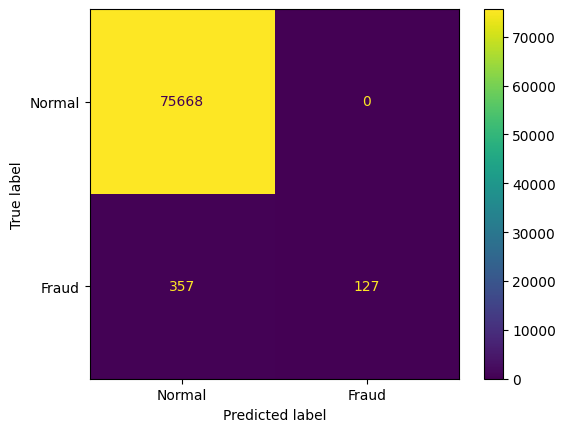

2380/2380 [==============================] - 10s 4ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epsilon = 0.251, Eps = 0.25


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


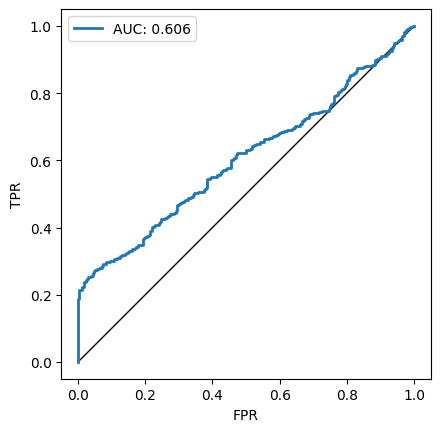

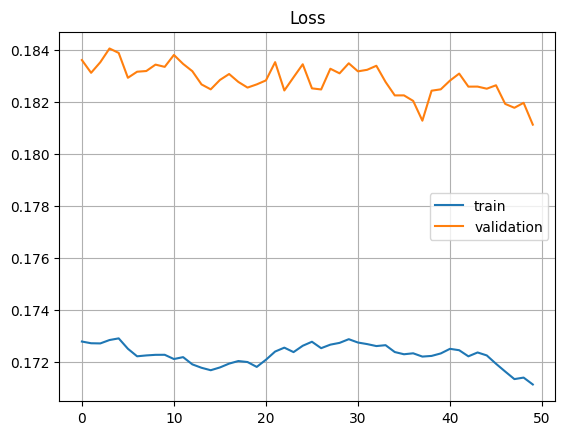

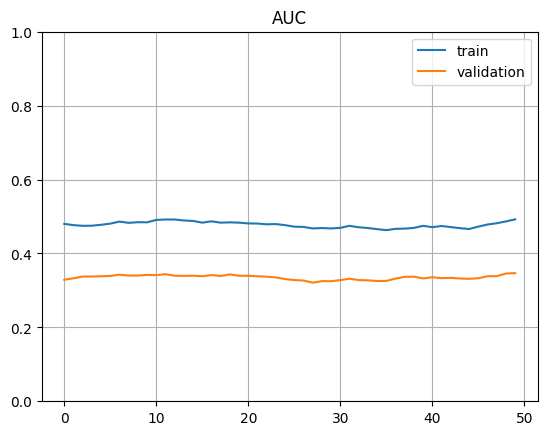

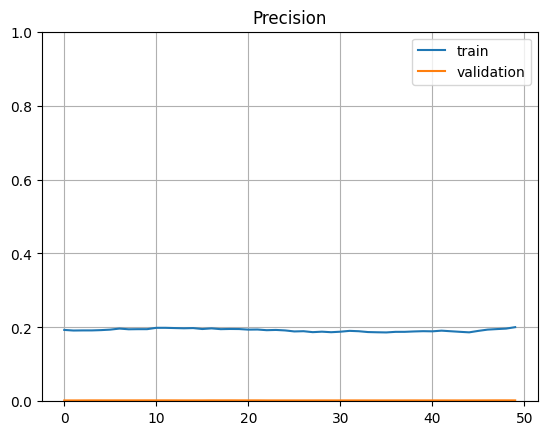

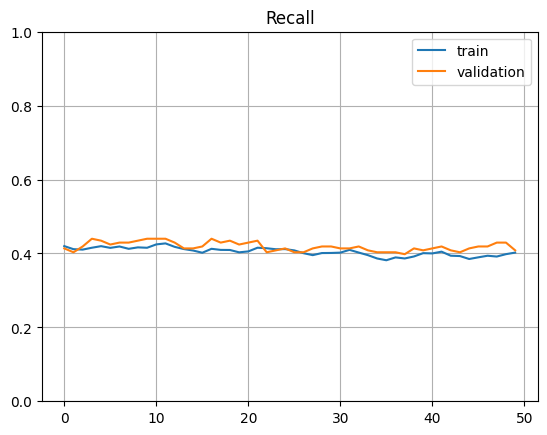

2380/2380 [==============================] - 11s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.29      0.45     75668
           1       0.00      0.55      0.01       484

    accuracy                           0.30     76152
   macro avg       0.50      0.42      0.23     76152
weighted avg       0.98      0.30      0.45     76152

Confusion Matrix:


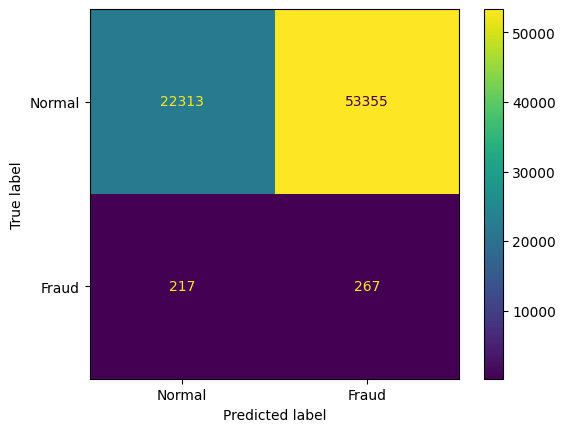

2380/2380 [==============================] - 10s 4ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epsilon = 0.501, Eps = 0.5


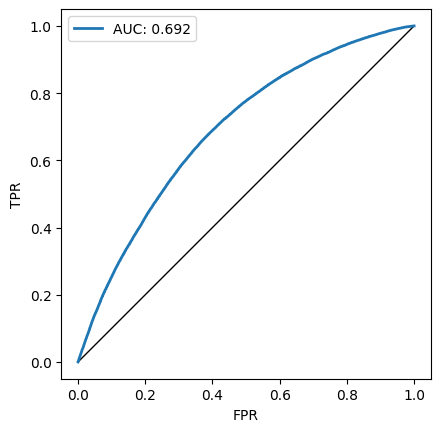

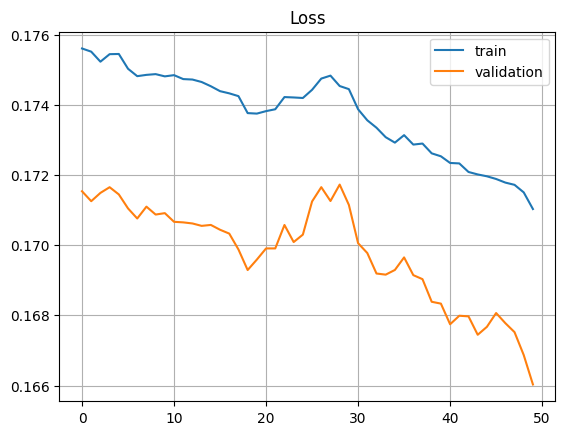

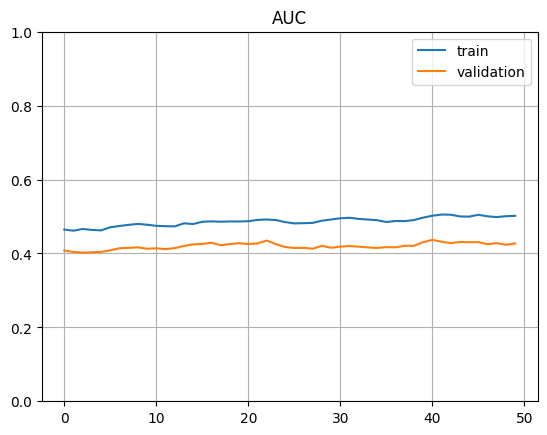

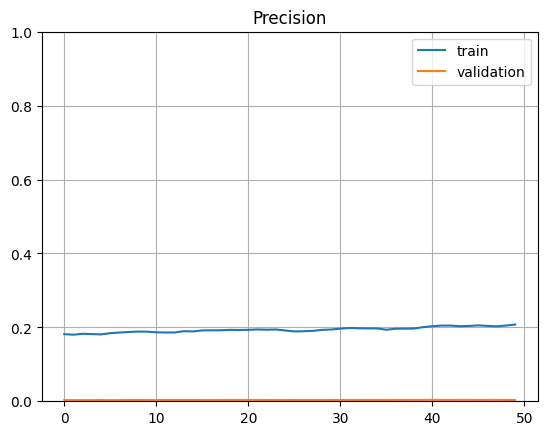

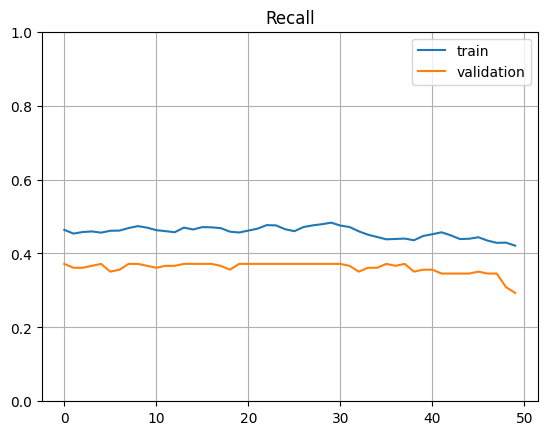

2380/2380 [==============================] - 11s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.69      0.81     75668
           1       0.01      0.28      0.01       484

    accuracy                           0.68     76152
   macro avg       0.50      0.48      0.41     76152
weighted avg       0.99      0.68      0.81     76152

Confusion Matrix:


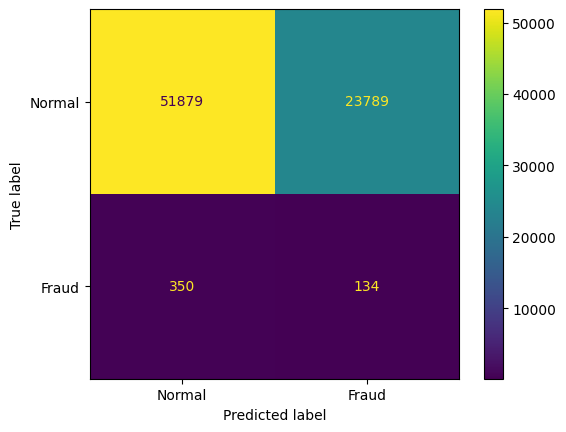

2380/2380 [==============================] - 9s 4ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epsilon = 0.751, Eps = 0.75


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


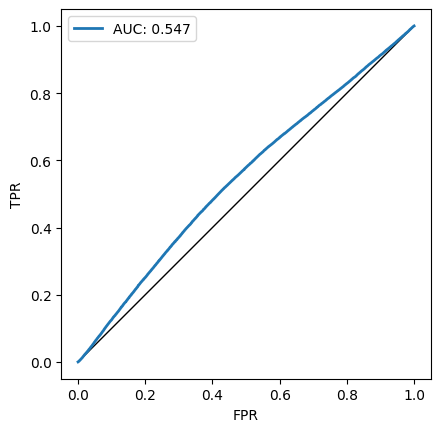

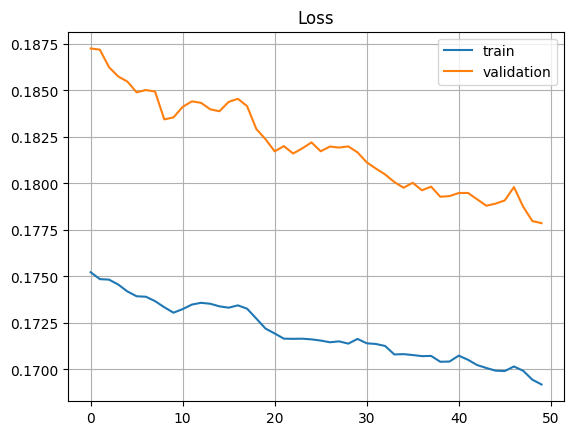

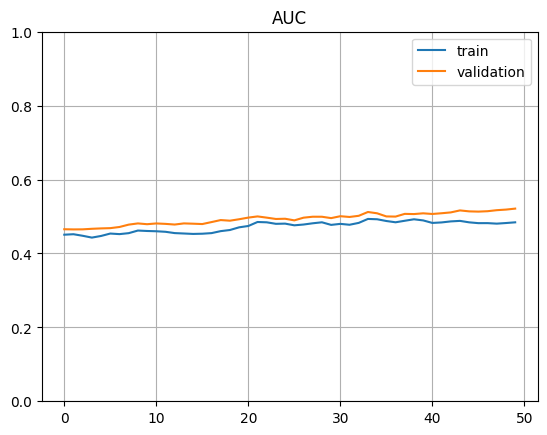

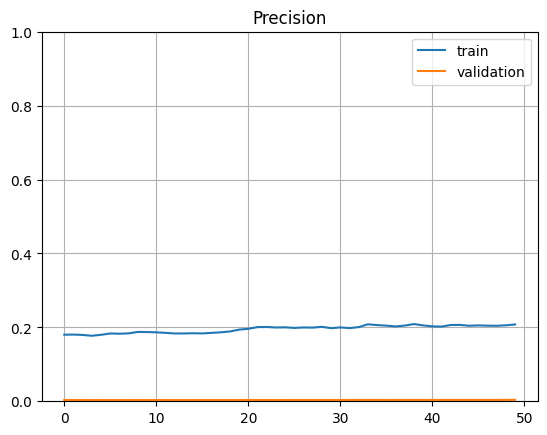

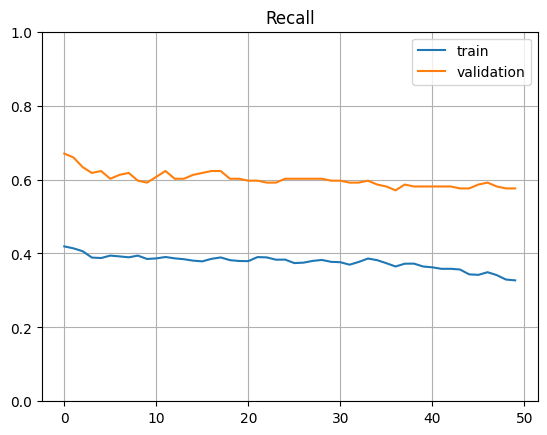

2380/2380 [==============================] - 12s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.44      0.61     75668
           1       0.01      0.60      0.01       484

    accuracy                           0.44     76152
   macro avg       0.50      0.52      0.31     76152
weighted avg       0.99      0.44      0.60     76152

Confusion Matrix:


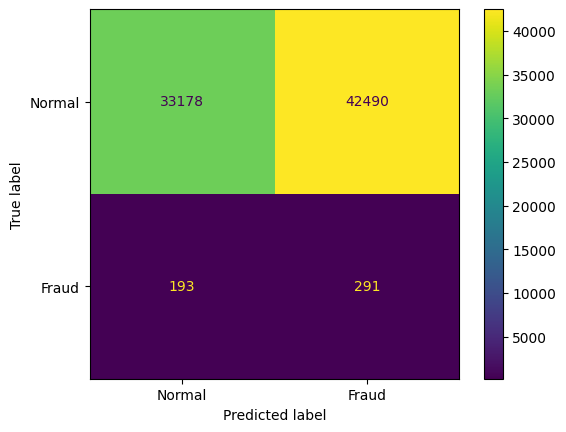

2380/2380 [==============================] - 10s 4ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

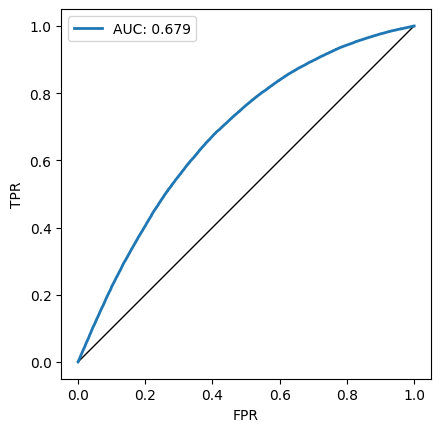

In [106]:
from services.eval_privacy import compute_mia_attacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

attacks_results_dict = {}
for eps, res_dict in results_per_eps.items():
    result = res_dict[max(res_dict.keys())]
    model = result['model']
    history = result['history']

    print(f"Epsilon = {result['epsilon']}, Eps = {eps}")
    plt.figure()
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(history.history['auc'], label='train')
    plt.plot(history.history['val_auc'], label='validation')
    plt.title('AUC')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(history.history['precision'], label='train')
    plt.plot(history.history['val_precision'], label='validation')
    plt.title('Precision')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(history.history['recall'], label='train')
    plt.plot(history.history['val_recall'], label='validation')
    plt.title('Recall')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

    y_pred = model.predict(X_test_seq)
    print("Classification Report:")
    print(classification_report(y_test_seq, y_pred > 0.5))

    # Create a confusion matrix
    conf_matrix = confusion_matrix(y_test_seq, y_pred > 0.5)
    print("Confusion Matrix:")
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Fraud'])
    disp.plot()
    plt.show()

    attacks_result, figure = compute_mia_attacks(model, X_train_seq[len(X_train_seq) - X_test_seq.shape[0]:], X_test_seq, y_train_seq[len(X_train_seq) - X_test_seq.shape[0]:], y_test_seq)
    attacks_results_dict[eps] = attacks_result

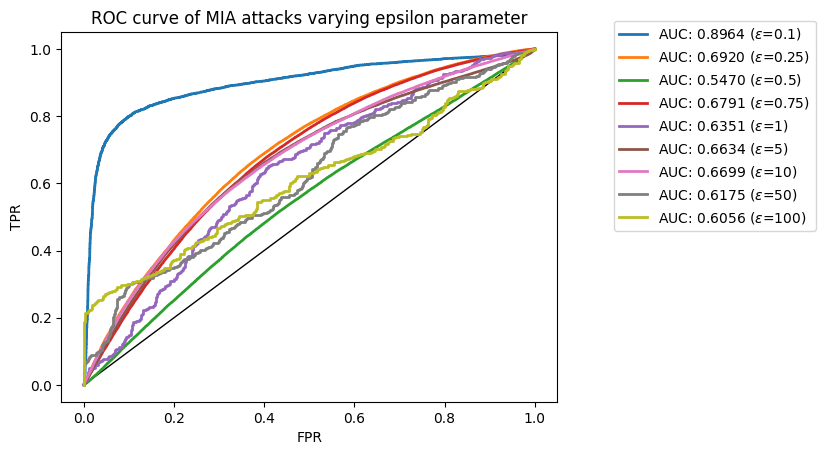

In [111]:
from sklearn import metrics

fig = plt.figure()
plt.plot([0, 1], [0, 1], 'k', lw=1.0)

sorted_attacks = sorted(attacks_results_dict.items(), key=lambda x: x[0])

for eps, attack_result in sorted_attacks:
    x = attack_result.get_result_with_max_auc().roc_curve.fpr
    y = attack_result.get_result_with_max_auc().roc_curve.tpr
    auc = metrics.auc(x, y)
    plt.plot(x, y, lw=2, label=f'AUC: {auc:.4f} ($\epsilon$={eps})')
plt.title('ROC curve of MIA attacks varying epsilon parameter')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

In [115]:
from services.dp_modeling import calculate_noise_multiplier

delta = 1e-6
dataset_size = len(X_train_seq)
target_epsilon = 1.0
batch_size = 256
noise_multiplier = 1.0
epochs = 50
microbatching = True

calculate_noise_multiplier(delta, epochs, batch_size, dataset_size, target_epsilon, microbatching)

{'noise_multiplier': 64.04588834762572,
 'privacy_metrics': {'parameters': {'examples': 157864,
   'batch_size': 256,
   'epochs': 50,
   'microbatching': True},
  'guarantees': {'delta': 1e-06,
   'epsilon_conservative': 1.001,
   'epsilon_poisson': 0.033}},
 'epsilon': 1.001}

In [116]:
from services.dp_modeling import train_model_with_delta

best_hp['num_microbatches'] = 1
best_hp['l2_norm_clip'] = 1.0
best_hp['learning_rate'] = 0.00001

eps = 5

delta_values = [1e-6*10**(-i) for i in range(3)]

results = {}

for delta in delta_values:
    print(f"δ={delta:.1e}")
    results[delta] = train_model_with_delta(delta, X_train, y_train, X_val, y_val, best_hp, target_epsilon=float(eps), epochs=50, batch_size=256)


δ=1.0e-06
δ=1.0e-06: Using noise_multiplier=7.344 (Achieved ε=5.00)
Train shape: (195317, 5, 29)
Val shape: (50779, 5, 29)
Class balance: (array([0, 1]), array([156254,  39063], dtype=int64))
Epoch 1/50
763/763 [==============================] - 78s 29ms/step - loss: 0.1711 - accuracy: 0.5702 - precision: 0.2688 - recall: 0.6680 - auc: 0.6584 - val_loss: 0.1556 - val_accuracy: 0.8192 - val_precision: 0.0047 - val_recall: 0.2251 - val_auc: 0.5143
Epoch 2/50
763/763 [==============================] - 20s 27ms/step - loss: 0.1709 - accuracy: 0.5753 - precision: 0.2715 - recall: 0.6675 - auc: 0.6597 - val_loss: 0.1554 - val_accuracy: 0.8219 - val_precision: 0.0047 - val_recall: 0.2199 - val_auc: 0.5167
Epoch 3/50
763/763 [==============================] - 20s 27ms/step - loss: 0.1708 - accuracy: 0.5752 - precision: 0.2709 - recall: 0.6647 - auc: 0.6597 - val_loss: 0.1554 - val_accuracy: 0.8222 - val_precision: 0.0048 - val_recall: 0.2251 - val_auc: 0.5173
Epoch 4/50
763/763 [==============

In [118]:
results

{1e-06: {'model': <keras.src.engine.sequential.Sequential at 0x1dd52a7f110>,
  'history': <keras.src.callbacks.History at 0x1dd56a21410>,
  'epsilon': 5.003,
  'noise_multiplier': 7.344284893035889},
 1e-07: {'model': <keras.src.engine.sequential.Sequential at 0x1dc6359d7d0>,
  'history': <keras.src.callbacks.History at 0x1dcde3dfdd0>,
  'epsilon': 5.0,
  'noise_multiplier': 7.916488910675048},
 1e-08: {'model': <keras.src.engine.sequential.Sequential at 0x1dc96c29910>,
  'history': <keras.src.callbacks.History at 0x1dc96bcb210>,
  'epsilon': 5.0,
  'noise_multiplier': 8.45054599380493}}

Epsilon = 5.003, Delta = 1e-06


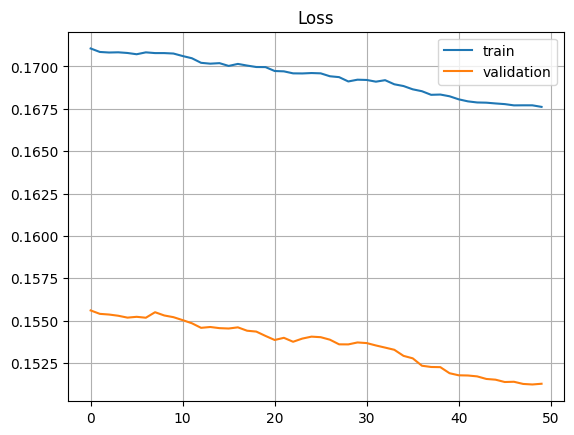

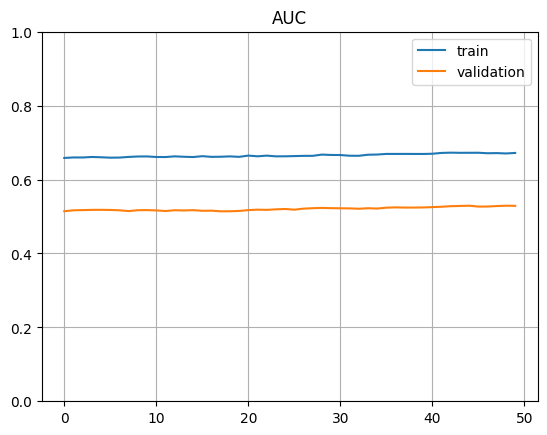

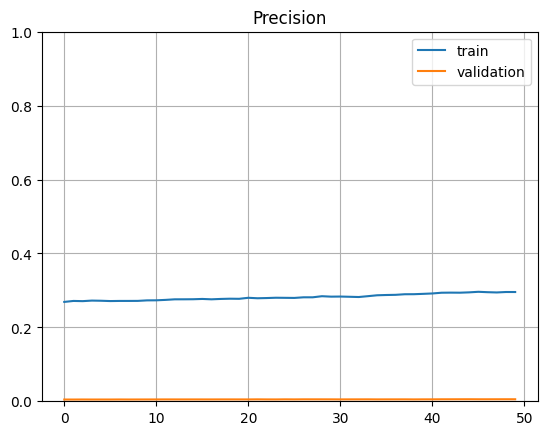

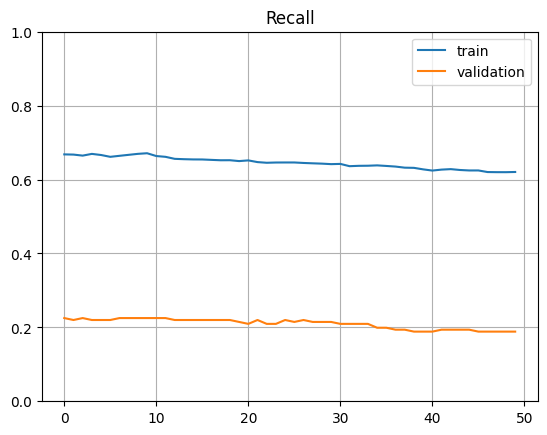

2380/2380 [==============================] - 13s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     75668
           1       0.01      0.16      0.02       484

    accuracy                           0.88     76152
   macro avg       0.50      0.52      0.48     76152
weighted avg       0.99      0.88      0.93     76152

Confusion Matrix:


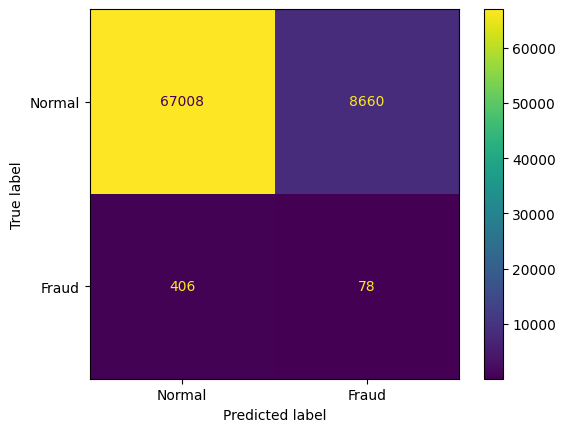

2380/2380 [==============================] - 13s 5ms/step


In [ ]:
from services.eval_privacy import compute_mia_attacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

attacks_results_dict = {}
for delta, result in results.items():
    model = result['model']
    history = result['history']

    print(f"Epsilon = {result['epsilon']}, Delta = {delta}") 
    plt.figure()
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(history.history['auc'], label='train')
    plt.plot(history.history['val_auc'], label='validation')
    plt.title('AUC')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(history.history['precision'], label='train')
    plt.plot(history.history['val_precision'], label='validation')
    plt.title('Precision')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(history.history['recall'], label='train')
    plt.plot(history.history['val_recall'], label='validation')
    plt.title('Recall')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()

    y_pred = model.predict(X_test_seq)
    print("Classification Report:")
    print(classification_report(y_test_seq, y_pred > 0.5))

    # Create a confusion matrix
    conf_matrix = confusion_matrix(y_test_seq, y_pred > 0.5)
    print("Confusion Matrix:")
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Fraud'])
    disp.plot()
    plt.show()

    attacks_result, figure = compute_mia_attacks(model, X_train_seq[len(X_train_seq) - X_test_seq.shape[0]:], X_test_seq, y_train_seq[len(X_train_seq) - X_test_seq.shape[0]:], y_test_seq)
    attacks_results_dict[delta] = attacks_result